# Examining the Factors Behind Political Candidates’ Success

Brandon Hong, Eddie Liu, Zayan Khanmohammed, Amy Zhong

DATA C102: Data, Inference, and Decisions

May 8, 2023

## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from urllib.request import urlretrieve
import statsmodels.api as sm
from pymc3 import *
import pymc3 as pm
import arviz as az
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import plot_tree
from scipy.stats import chi2_contingency
from pingouin import power_chi2
  
%matplotlib inline
sns.set(style="dark")
plt.style.use("ggplot")

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
urlretrieve("https://raw.githubusercontent.com/fivethirtyeight/data/master/primary-candidates-2018/dem_candidates.csv", 'dem.csv')

('dem.csv', <http.client.HTTPMessage at 0x7fee81ec4700>)

In [3]:
urlretrieve("https://raw.githubusercontent.com/fivethirtyeight/data/master/primary-candidates-2018/rep_candidates.csv", 'rep.csv')

('rep.csv', <http.client.HTTPMessage at 0x7fee81ec4610>)

In [4]:
rep = pd.read_csv('rep.csv', sep=',', encoding='latin-1')
rep.head()

Candidate State            District Office Type Race Type   
0    Mike Dunleavy    AK  Governor of Alaska    Governor   Regular  \
1  Michael Sheldon    AK  Governor of Alaska    Governor   Regular   
2   Mead Treadwell    AK  Governor of Alaska    Governor   Regular   
3     Darin Colbry    AK  Governor of Alaska    Governor   Regular   
4    Thomas Gordon    AK  Governor of Alaska    Governor   Regular   

  Race Primary Election Date Primary Status Primary Runoff Status   
0                    8/21/18       Advanced                   NaN  \
1                    8/21/18           Lost                   NaN   
2                    8/21/18           Lost                   NaN   
3                    8/21/18           Lost                   NaN   
4                    8/21/18           Lost                   NaN   

  General Status  Primary %  ... NRA Endorsed? Right to Life Endorsed?   
0  On the Ballot       61.8  ...           NaN                     NaN  \
1            NaN        2.2  ...           NaN                     NaN   
2            NaN       31.9  ...           NaN                     NaN   
3            NaN        0.6  ...           NaN                     NaN   
4            NaN        1.3  ...           NaN                     NaN   

  Susan B. Anthony Endorsed? Club for Growth Endorsed? Koch Support?   
0                        NaN                       NaN           NaN  \
1                        NaN                       NaN           NaN   
2                        NaN                       NaN           NaN   
3                        NaN                       NaN           NaN   
4                        NaN                       NaN           NaN   

  House Freedom Support? Tea Party Endorsed? Main Street Endorsed?   
0                    NaN                 NaN                   NaN  \
1                    NaN                 NaN                   NaN   
2                    NaN                 NaN                   NaN   
3                    NaN                 NaN                   NaN   
4                    NaN                 NaN                   NaN   

  Chamber Endorsed? No Labels Support?  
0               NaN                NaN  
1               NaN                NaN  
2               NaN                NaN  
3               NaN                NaN  
4               NaN                NaN  

[5 rows x 25 columns]

In [5]:
dem = pd.read_csv('dem.csv', sep=',', encoding='latin-1')
dem.head()

Candidate State             District Office Type Race Type   
0  Anthony White (Alabama)    AL  Governor of Alabama    Governor   Regular  \
1   Christopher Countryman    AL  Governor of Alabama    Governor   Regular   
2    Doug "New Blue" Smith    AL  Governor of Alabama    Governor   Regular   
3          James C. Fields    AL  Governor of Alabama    Governor   Regular   
4            Sue Bell Cobb    AL  Governor of Alabama    Governor   Regular   

  Race Primary Election Date Primary Status Primary Runoff Status   
0                     6/5/18           Lost                   NaN  \
1                     6/5/18           Lost                   NaN   
2                     6/5/18           Lost                   NaN   
3                     6/5/18           Lost                   NaN   
4                     6/5/18           Lost                   NaN   

  General Status  Partisan Lean  ...  Biden Endorsed? Warren Endorsed?    
0            NaN     -28.879999  ...              NaN               NaN  \
1            NaN     -28.879999  ...              NaN               NaN   
2            NaN     -28.879999  ...              NaN               NaN   
3            NaN     -28.879999  ...              NaN               NaN   
4            NaN     -28.879999  ...              NaN               NaN   

  Sanders Endorsed? Our Revolution Endorsed? Justice Dems Endorsed?   
0               NaN                      NaN                    NaN  \
1               NaN                      NaN                    NaN   
2               NaN                      NaN                    NaN   
3               NaN                      NaN                    NaN   
4               NaN                      NaN                    NaN   

  PCCC Endorsed? Indivisible Endorsed? WFP Endorsed? VoteVets Endorsed?   
0            NaN                   NaN           NaN                NaN  \
1            NaN                   NaN           NaN                NaN   
2            NaN                   NaN           NaN                NaN   
3            NaN                   NaN           NaN                NaN   
4            NaN                   NaN           NaN                NaN   

  No Labels Support?  
0                NaN  
1                NaN  
2                NaN  
3                NaN  
4                NaN  

[5 rows x 32 columns]

## Cleaning

In [6]:
#creating a new quantitative column
#dem.groupby(['State', 'District', 'Race Primary Election Date']).count().reset_index()[['Race Primary Election Date', 'Candidate']]

In [7]:
dem_number_of_candidates = dem.groupby(['State', 'District', 'Race Primary Election Date'])['Candidate'].transform('count')
rep_number_of_candidates = rep.groupby(['State', 'District', 'Race Primary Election Date'])['Candidate'].transform('count')
dem['number_of_candidates'] = dem_number_of_candidates
rep['number_of_candidates'] = dem_number_of_candidates
dem.head(5)

Candidate State             District Office Type Race Type   
0  Anthony White (Alabama)    AL  Governor of Alabama    Governor   Regular  \
1   Christopher Countryman    AL  Governor of Alabama    Governor   Regular   
2    Doug "New Blue" Smith    AL  Governor of Alabama    Governor   Regular   
3          James C. Fields    AL  Governor of Alabama    Governor   Regular   
4            Sue Bell Cobb    AL  Governor of Alabama    Governor   Regular   

  Race Primary Election Date Primary Status Primary Runoff Status   
0                     6/5/18           Lost                   NaN  \
1                     6/5/18           Lost                   NaN   
2                     6/5/18           Lost                   NaN   
3                     6/5/18           Lost                   NaN   
4                     6/5/18           Lost                   NaN   

  General Status  Partisan Lean  ...  Warren Endorsed?  Sanders Endorsed?   
0            NaN     -28.879999  ...                NaN               NaN  \
1            NaN     -28.879999  ...                NaN               NaN   
2            NaN     -28.879999  ...                NaN               NaN   
3            NaN     -28.879999  ...                NaN               NaN   
4            NaN     -28.879999  ...                NaN               NaN   

  Our Revolution Endorsed? Justice Dems Endorsed? PCCC Endorsed?   
0                      NaN                    NaN            NaN  \
1                      NaN                    NaN            NaN   
2                      NaN                    NaN            NaN   
3                      NaN                    NaN            NaN   
4                      NaN                    NaN            NaN   

  Indivisible Endorsed? WFP Endorsed? VoteVets Endorsed? No Labels Support?   
0                   NaN           NaN                NaN                NaN  \
1                   NaN           NaN                NaN                NaN   
2                   NaN           NaN                NaN                NaN   
3                   NaN           NaN                NaN                NaN   
4                   NaN           NaN                NaN                NaN   

  number_of_candidates  
0                    6  
1                    6  
2                    6  
3                    6  
4                    6  

[5 rows x 33 columns]

In [8]:
#remove redundant columns
dem = dem.drop(columns = ['Race Type', 'Primary Runoff Status', 'General Status', 'Primary Status'])
rep = rep.drop(columns = ['Race Type', 'Primary Runoff Status', 'General Status', 'Primary Status'])

In [9]:
dem = dem.fillna(0)
rep = rep.fillna(0)

In [10]:
#change yes to 1 and no to 0
#if they did not receive an endorsment or support, the value should be 0 
for i in np.arange(9, 28):
    dem.iloc[:, i] = dem.iloc[:, i].map({'Yes': 1, 'No': 0, 0 : 0})
dem = dem.fillna(0)
dem['Won Primary'] = dem['Won Primary'].map({'Yes': 1, 'No': 0, 0 : 0})
dem.head()

Candidate State             District Office Type   
0  Anthony White (Alabama)    AL  Governor of Alabama    Governor  \
1   Christopher Countryman    AL  Governor of Alabama    Governor   
2    Doug "New Blue" Smith    AL  Governor of Alabama    Governor   
3          James C. Fields    AL  Governor of Alabama    Governor   
4            Sue Bell Cobb    AL  Governor of Alabama    Governor   

  Race Primary Election Date  Partisan Lean  Primary %  Won Primary      Race   
0                     6/5/18     -28.879999       3.42            0  Nonwhite  \
1                     6/5/18     -28.879999       1.74            0     White   
2                     6/5/18     -28.879999       3.27            0     White   
3                     6/5/18     -28.879999       8.00            0  Nonwhite   
4                     6/5/18     -28.879999      28.98            0     White   

   Veteran?  ...  Warren Endorsed?   Sanders Endorsed?   
0         1  ...                  0                  0  \
1         0  ...                  0                  0   
2         1  ...                  0                  0   
3         1  ...                  0                  0   
4         0  ...                  0                  0   

   Our Revolution Endorsed?  Justice Dems Endorsed?  PCCC Endorsed?   
0                         0                       0               0  \
1                         0                       0               0   
2                         0                       0               0   
3                         0                       0               0   
4                         0                       0               0   

   Indivisible Endorsed?  WFP Endorsed?  VoteVets Endorsed?   
0                      0              0                   0  \
1                      0              0                   0   
2                      0              0                   0   
3                      0              0                   0   
4                      0              0                   0   

   No Labels Support?  number_of_candidates  
0                   0                     6  
1                   0                     6  
2                   0                     6  
3                   0                     6  
4                   0                     6  

[5 rows x 29 columns]

In [11]:
#change yes to 1 and no to 0
#if they did not receive an endorsment or support, the value should be 0 
for i in np.arange(6, 21):
    rep.iloc[:, i] = rep.iloc[:, i].map({'Yes': 1, 'No': 0, 0:0})
rep = rep.fillna(0)
rep['Won Primary'] = rep['Won Primary'].map({'Yes': 1, 'No': 0, 0 : 0})
rep.head()

Candidate State            District Office Type   
0    Mike Dunleavy    AK  Governor of Alaska    Governor  \
1  Michael Sheldon    AK  Governor of Alaska    Governor   
2   Mead Treadwell    AK  Governor of Alaska    Governor   
3     Darin Colbry    AK  Governor of Alaska    Governor   
4    Thomas Gordon    AK  Governor of Alaska    Governor   

  Race Primary Election Date  Primary %  Won Primary  Rep Party Support?   
0                    8/21/18       61.8          NaN                   0  \
1                    8/21/18        2.2          0.0                   0   
2                    8/21/18       31.9          0.0                   0   
3                    8/21/18        0.6          0.0                   0   
4                    8/21/18        1.3          0.0                   0   

   Trump Endorsed?  Bannon Endorsed?  ...  Right to Life Endorsed?   
0                0                 0  ...                        0  \
1                0                 0  ...                        0   
2                0                 0  ...                        0   
3                0                 0  ...                        0   
4                0                 0  ...                        0   

   Susan B. Anthony Endorsed?  Club for Growth Endorsed?  Koch Support?   
0                           0                          0              0  \
1                           0                          0              0   
2                           0                          0              0   
3                           0                          0              0   
4                           0                          0              0   

   House Freedom Support?  Tea Party Endorsed?  Main Street Endorsed?   
0                       0                    0                      0  \
1                       0                    0                      0   
2                       0                    0                      0   
3                       0                    0                      0   
4                       0                    0                      0   

   Chamber Endorsed?  No Labels Support?  number_of_candidates  
0                  0                   0                     6  
1                  0                   0                     6  
2                  0                   0                     6  
3                  0                   0                     6  
4                  0                   0                     6  

[5 rows x 22 columns]

## EDA

### Brandon

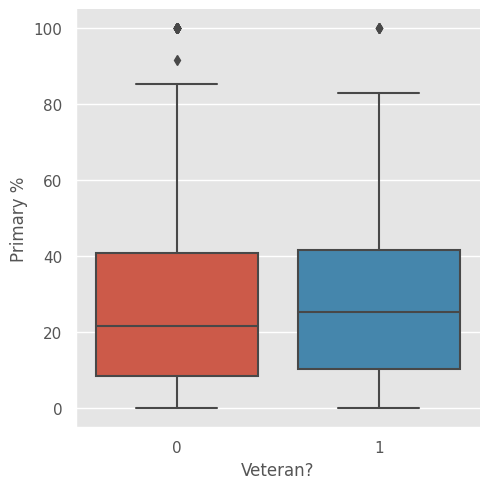

In [12]:
sns.catplot(data=dem, x="Veteran?", y="Primary %", kind="box")

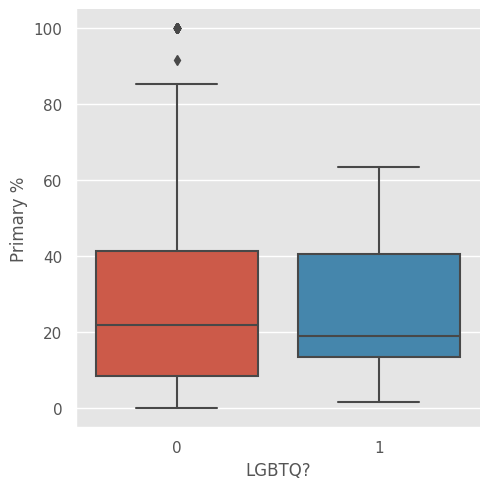

In [13]:
sns.catplot(data=dem, x='LGBTQ?', y="Primary %", kind="box")

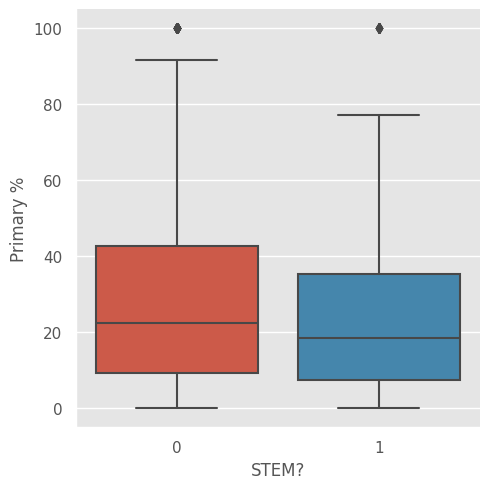

In [14]:
sns.catplot(data=dem, x='STEM?', y="Primary %", kind="box")

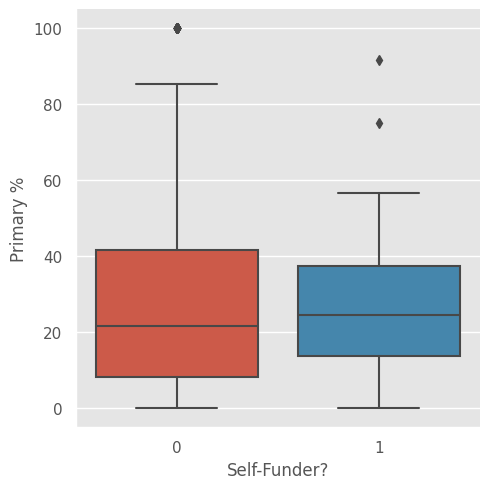

In [15]:
sns.catplot(data=dem, x='Self-Funder?', y="Primary %", kind="box")

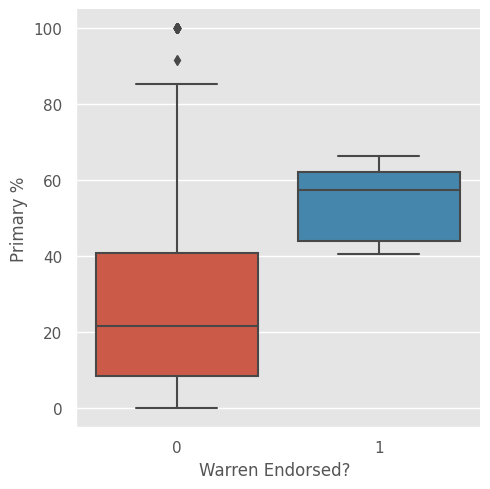

In [16]:
sns.catplot(data=dem, x='Warren Endorsed? ', y="Primary %", kind="box")

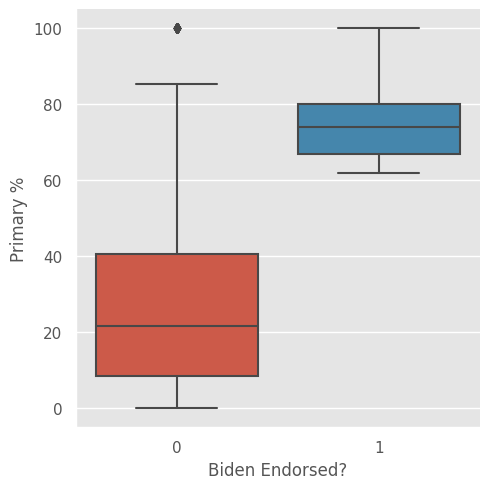

In [17]:
sns.catplot(data=dem, x='Biden Endorsed?', y="Primary %", kind="box")

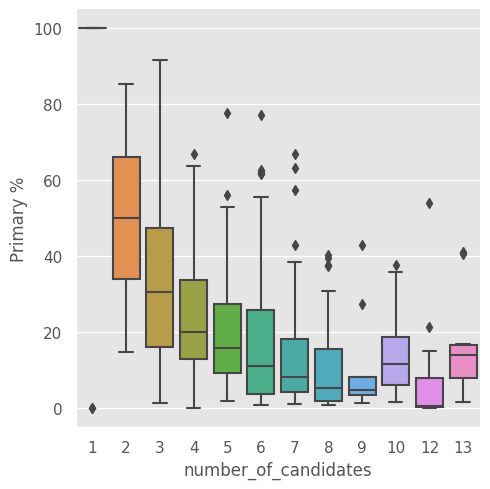

In [18]:
sns.catplot(data=dem, x="number_of_candidates", y="Primary %", kind="box")

Categorical: Based on the box plots that I created with the categorical variables, the primary percentage was higher when a candidate was endorsed. Some endorsments seemed to favor candidates more heavily than other candidates. Some categorical variables that are not present in the Republican dataset also seemed to not have an effect, such as Veteran, LGBTQ, STEM, and whether they were self-funded. I think it is interesting that these variables either did not help the candidates or only slightly helped them. I think it is worth out time to investigate why these variables are not as impactful as the other categorical variables. The box plots helped show how correlated the variables are with the primary percentage. Since we can determine which endorsments are highly correlated with high primary percentage, we can potentially used them in our GLM models to answer our second project question. 

Quantitiative: The last box plot graph shows the relationship between the primary percentage and number of candidates in each election. Logically, it makes more sense for the candidates to receive a lower primary percentage with more candidates, as there is more competition. This plot shows this general relationship, but there are some exceptions when there are more than 9 candidates. This can be something useful we may be able to use in our models. 

### Amy

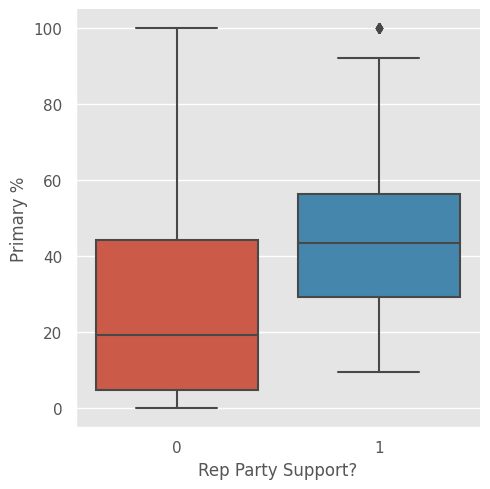

In [19]:
sns.catplot(data=rep, x="Rep Party Support?", y="Primary %", kind="box")

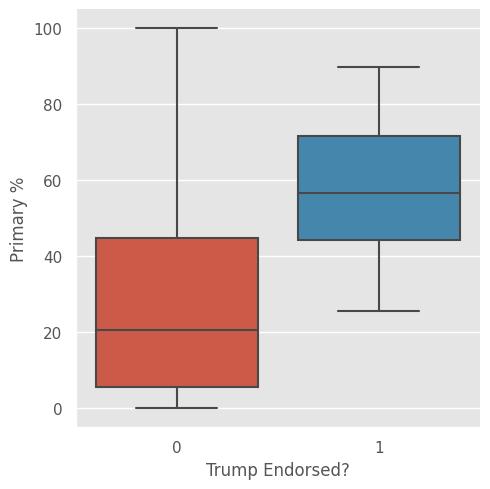

In [20]:
sns.catplot(data=rep, x="Trump Endorsed?", y="Primary %", kind="box")

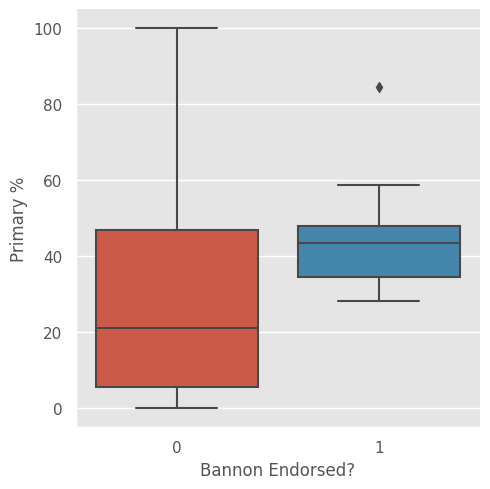

In [21]:
sns.catplot(data=rep, x="Bannon Endorsed?", y="Primary %", kind="box")

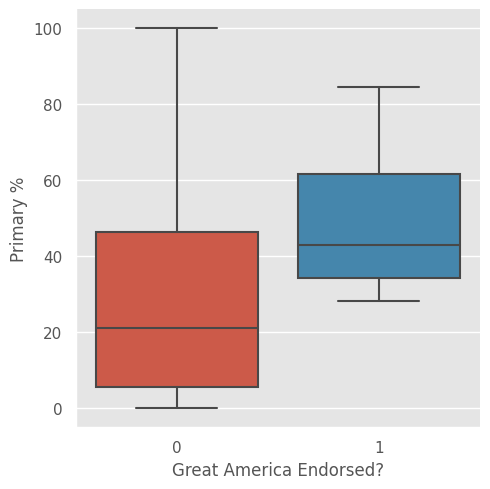

In [22]:
sns.catplot(data=rep, x="Great America Endorsed?", y="Primary %", kind="box")

In [23]:
sns.catplot(data=rep, x="NRA Endorsed?", y="Primary %", kind="box")

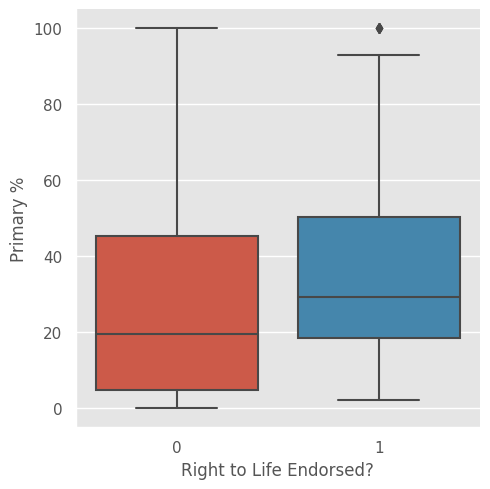

In [24]:
sns.catplot(data=rep, x="Right to Life Endorsed?", y="Primary %", kind="box")

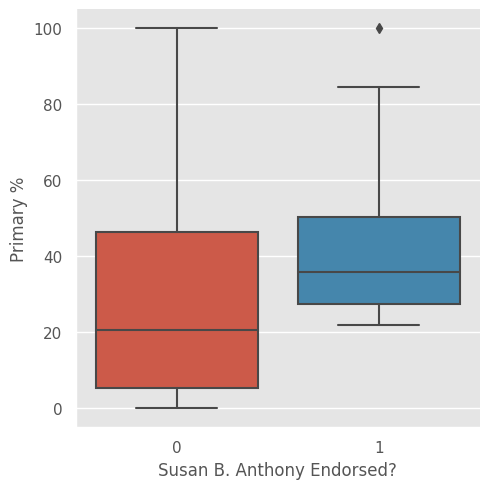

In [25]:
sns.catplot(data=rep, x="Susan B. Anthony Endorsed?", y="Primary %", kind="box")

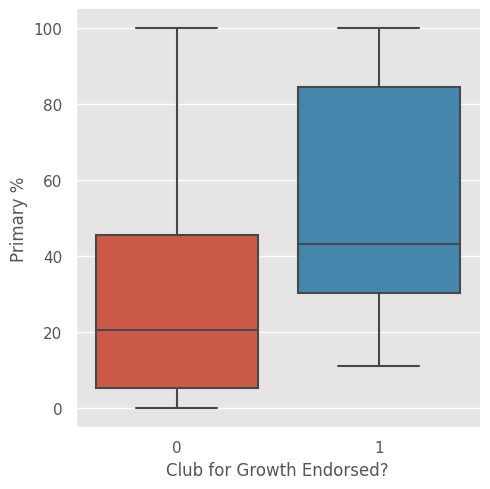

In [26]:
sns.catplot(data=rep, x="Club for Growth Endorsed?", y="Primary %", kind="box")

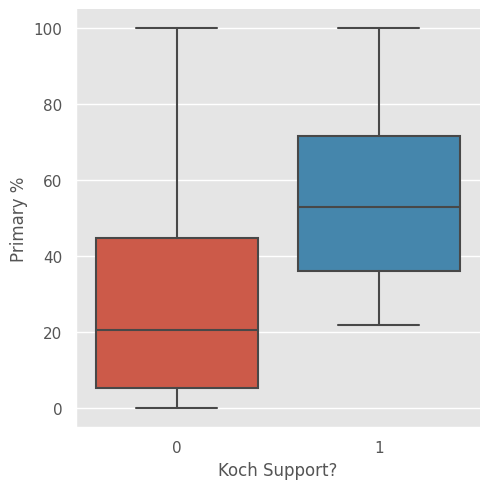

In [27]:
sns.catplot(data=rep, x="Koch Support?", y="Primary %", kind="box")

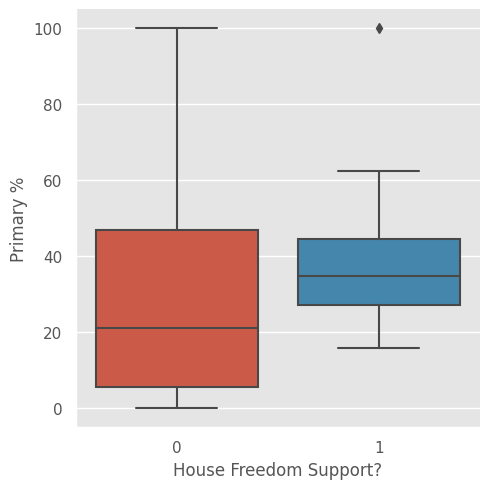

In [28]:
sns.catplot(data=rep, x="House Freedom Support?", y="Primary %", kind="box")

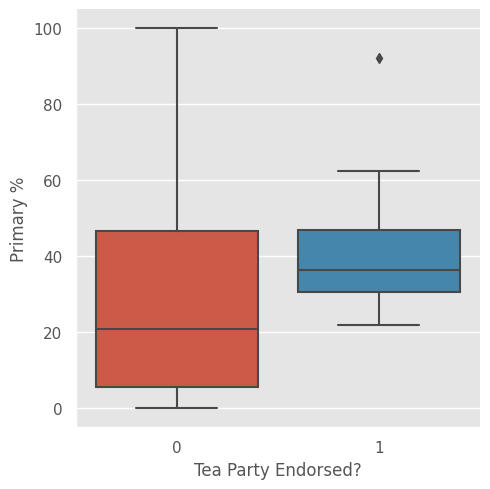

In [29]:
sns.catplot(data=rep, x="Tea Party Endorsed?", y="Primary %", kind="box")

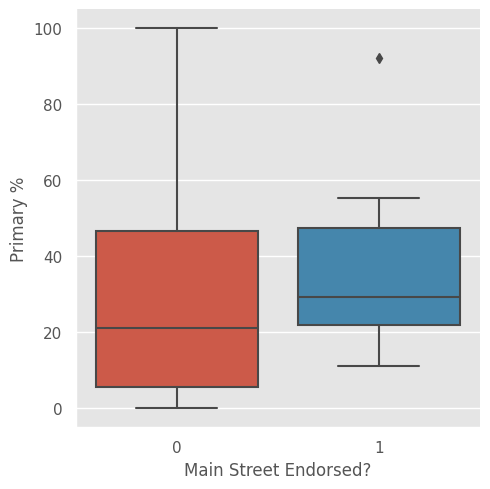

In [30]:
sns.catplot(data=rep, x="Main Street Endorsed?", y="Primary %", kind="box")

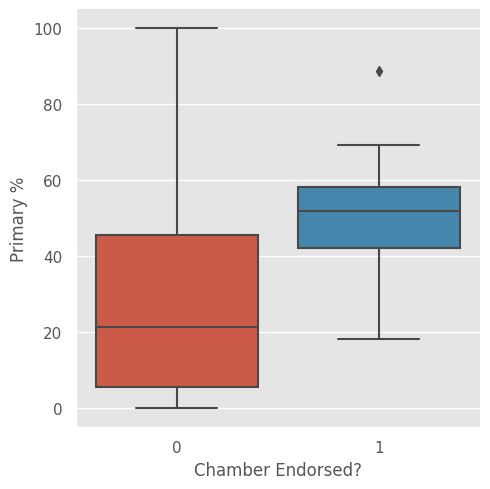

In [31]:
sns.catplot(data=rep, x="Chamber Endorsed?", y="Primary %", kind="box")

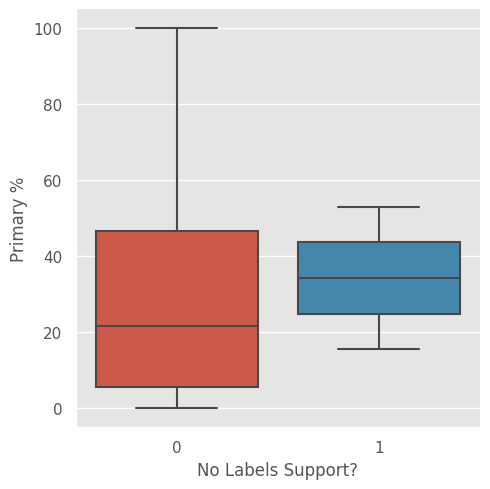

In [32]:
sns.catplot(data=rep, x="No Labels Support?", y="Primary %", kind="box")

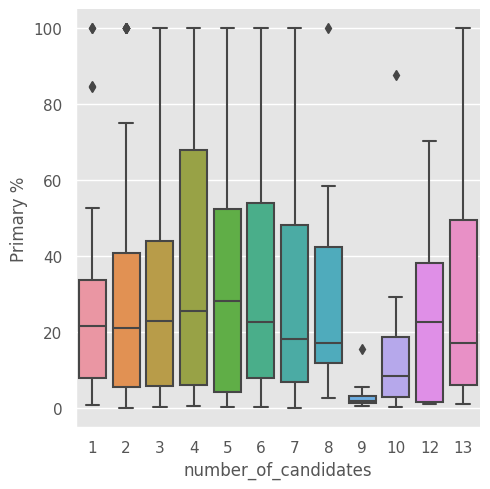

In [33]:
sns.catplot(data=rep, x="number_of_candidates", y="Primary %", kind="box")

Categorical:
Based on the box plots, all the supports/endorsed categories in the republican dataset have a greater primary % when endorse = yes. The increase in primary % from each category appears to vary. For example, the Trump, NRA, Koch, and Chamber Endorsed categories have a much higher primary % when endorsed versus when not endorsed. The other categories, though, appear to have a smaller increase in primary % when they are endorsed by the respective category. We might want to follow up on the Trump, NRA, Koch, and Chamber endorsed categories, as they might have greater influence on primary %. These individual box plots can help us choose which supports/categories help a candidate win the election. As mentioned in the previous answer, certain categories when endorsed = yes have a much higher primary %. These categories, such as Trump, NRA, Koch, and Chamber Endorsed, could potentially be answers to our project question and help us choose the list of support parties for both project question 1 and 2. While we want to look into those categories more to see if they can actually cause increase in primary %, we don't want to rule out the other endorsement categories yet. 

Quantitative: 
The last plot shows primary percentage v. number of candidates in each election. Generally, as number of candidates increases (from 1 to 10), the primary % decreases. As number of candidates increases though (from 10-19), the primary % appears to even out and appear roughly consistent. The number of candidates data can potentially help us predict primary % for the republican candidates, which aids us in answering project question 2. We can predict right now that more candidates will theoretically lead to lower primary percentage. This is an area we can dive into more when creating our actual models. 

### Eddie

In [34]:
dem_eddie = pd.read_csv('dem.csv', sep=',', encoding='latin-1')
dem_eddie.head()

Candidate State             District Office Type Race Type   
0  Anthony White (Alabama)    AL  Governor of Alabama    Governor   Regular  \
1   Christopher Countryman    AL  Governor of Alabama    Governor   Regular   
2    Doug "New Blue" Smith    AL  Governor of Alabama    Governor   Regular   
3          James C. Fields    AL  Governor of Alabama    Governor   Regular   
4            Sue Bell Cobb    AL  Governor of Alabama    Governor   Regular   

  Race Primary Election Date Primary Status Primary Runoff Status   
0                     6/5/18           Lost                   NaN  \
1                     6/5/18           Lost                   NaN   
2                     6/5/18           Lost                   NaN   
3                     6/5/18           Lost                   NaN   
4                     6/5/18           Lost                   NaN   

  General Status  Partisan Lean  ...  Biden Endorsed? Warren Endorsed?    
0            NaN     -28.879999  ...              NaN               NaN  \
1            NaN     -28.879999  ...              NaN               NaN   
2            NaN     -28.879999  ...              NaN               NaN   
3            NaN     -28.879999  ...              NaN               NaN   
4            NaN     -28.879999  ...              NaN               NaN   

  Sanders Endorsed? Our Revolution Endorsed? Justice Dems Endorsed?   
0               NaN                      NaN                    NaN  \
1               NaN                      NaN                    NaN   
2               NaN                      NaN                    NaN   
3               NaN                      NaN                    NaN   
4               NaN                      NaN                    NaN   

  PCCC Endorsed? Indivisible Endorsed? WFP Endorsed? VoteVets Endorsed?   
0            NaN                   NaN           NaN                NaN  \
1            NaN                   NaN           NaN                NaN   
2            NaN                   NaN           NaN                NaN   
3            NaN                   NaN           NaN                NaN   
4            NaN                   NaN           NaN                NaN   

  No Labels Support?  
0                NaN  
1                NaN  
2                NaN  
3                NaN  
4                NaN  

[5 rows x 32 columns]

In [35]:
rep_eddie = pd.read_csv('rep.csv', sep=',', encoding='latin-1')
rep_eddie.head()

Candidate State            District Office Type Race Type   
0    Mike Dunleavy    AK  Governor of Alaska    Governor   Regular  \
1  Michael Sheldon    AK  Governor of Alaska    Governor   Regular   
2   Mead Treadwell    AK  Governor of Alaska    Governor   Regular   
3     Darin Colbry    AK  Governor of Alaska    Governor   Regular   
4    Thomas Gordon    AK  Governor of Alaska    Governor   Regular   

  Race Primary Election Date Primary Status Primary Runoff Status   
0                    8/21/18       Advanced                   NaN  \
1                    8/21/18           Lost                   NaN   
2                    8/21/18           Lost                   NaN   
3                    8/21/18           Lost                   NaN   
4                    8/21/18           Lost                   NaN   

  General Status  Primary %  ... NRA Endorsed? Right to Life Endorsed?   
0  On the Ballot       61.8  ...           NaN                     NaN  \
1            NaN        2.2  ...           NaN                     NaN   
2            NaN       31.9  ...           NaN                     NaN   
3            NaN        0.6  ...           NaN                     NaN   
4            NaN        1.3  ...           NaN                     NaN   

  Susan B. Anthony Endorsed? Club for Growth Endorsed? Koch Support?   
0                        NaN                       NaN           NaN  \
1                        NaN                       NaN           NaN   
2                        NaN                       NaN           NaN   
3                        NaN                       NaN           NaN   
4                        NaN                       NaN           NaN   

  House Freedom Support? Tea Party Endorsed? Main Street Endorsed?   
0                    NaN                 NaN                   NaN  \
1                    NaN                 NaN                   NaN   
2                    NaN                 NaN                   NaN   
3                    NaN                 NaN                   NaN   
4                    NaN                 NaN                   NaN   

  Chamber Endorsed? No Labels Support?  
0               NaN                NaN  
1               NaN                NaN  
2               NaN                NaN  
3               NaN                NaN  
4               NaN                NaN  

[5 rows x 25 columns]

In [36]:
dem_varlist = ['Veteran?', 'LGBTQ?', 'Elected Official?', 'Self-Funder?', 'STEM?',
       'Obama Alum?', 'Party Support?', 'Emily Endorsed?',
       'Guns Sense Candidate?', 'Biden Endorsed?', 'Warren Endorsed? ',
       'Sanders Endorsed?', 'Our Revolution Endorsed?',
       'Justice Dems Endorsed?', 'PCCC Endorsed?', 'Indivisible Endorsed?',
       'WFP Endorsed?', 'VoteVets Endorsed?', 'No Labels Support?']
rep_varlist = ['Rep Party Support?',
       'Trump Endorsed?', 'Bannon Endorsed?', 'Great America Endorsed?',
       'NRA Endorsed?', 'Right to Life Endorsed?',
       'Susan B. Anthony Endorsed?', 'Club for Growth Endorsed?',
       'Koch Support?', 'House Freedom Support?', 'Tea Party Endorsed?',
       'Main Street Endorsed?', 'Chamber Endorsed?']

In [37]:
for var in dem_varlist:
    dem_eddie[var] = (dem_eddie[var] == 'Yes') * 1
for var in rep_varlist:
    rep_eddie[var] = (rep_eddie[var] == 'Yes') * 1

In [38]:
dem_won = dem_eddie[dem_eddie['Won Primary'] == 'Yes']
rep_won = rep_eddie[rep_eddie['Won Primary'] == 'Yes']
dem_won.head()

Candidate State                       District     Office Type   
5          Walt Maddox    AL            Governor of Alabama        Governor  \
7   Robert Kennedy Jr.    AL  U.S. House Alabama District 1  Representative   
9        Tabitha Isner    AL  U.S. House Alabama District 2  Representative   
11       Mallory Hagan    AL  U.S. House Alabama District 3  Representative   
12           Lee Auman    AL  U.S. House Alabama District 4  Representative   

   Race Type Race Primary Election Date Primary Status Primary Runoff Status   
5    Regular                     6/5/18       Advanced                   NaN  \
7    Regular                     6/5/18       Advanced                   NaN   
9    Regular                     6/5/18       Advanced                   NaN   
11   Regular                     6/5/18       Advanced                   NaN   
12   Regular                     6/5/18       Advanced                   NaN   

   General Status  Partisan Lean  ...  Biden Endorsed? Warren Endorsed?    
5   On the Ballot     -28.879999  ...                0                 0  \
7   On the Ballot     -30.680000  ...                0                 0   
9   On the Ballot     -33.080002  ...                0                 0   
11  On the Ballot     -33.660000  ...                0                 0   
12  On the Ballot     -62.480000  ...                0                 0   

   Sanders Endorsed?  Our Revolution Endorsed?  Justice Dems Endorsed?   
5                  0                         0                       0  \
7                  0                         0                       0   
9                  0                         0                       0   
11                 0                         0                       0   
12                 0                         0                       0   

    PCCC Endorsed?  Indivisible Endorsed?  WFP Endorsed?  VoteVets Endorsed?   
5                0                      0              0                   0  \
7                0                      0              0                   0   
9                0                      0              0                   0   
11               0                      0              0                   0   
12               0                      0              0                   0   

    No Labels Support?  
5                    0  
7                    0  
9                    0  
11                   0  
12                   0  

[5 rows x 32 columns]

In [39]:
dem_list = []
for var in dem_varlist:
    dem_list.append(dem_won[var].mean())

rep_list = []
for var in rep_varlist:
    rep_list.append(rep_won[var].mean())
    
print(dem_list)
print(rep_list)

[0.1506276150627615, 0.04184100418410042, 0.24267782426778242, 0.0502092050209205, 0.13807531380753138, 0.05439330543933055, 0.15481171548117154, 0.16317991631799164, 0.3305439330543933, 0.04184100418410042, 0.02092050209205021, 0.02092050209205021, 0.11297071129707113, 0.06694560669456066, 0.04184100418410042, 0.12552301255230125, 0.06276150627615062, 0.06694560669456066, 0.0]
[0.15918367346938775, 0.061224489795918366, 0.024489795918367346, 0.02040816326530612, 0.0326530612244898, 0.1346938775510204, 0.04897959183673469, 0.053061224489795916, 0.07346938775510205, 0.02857142857142857, 0.04081632653061224, 0.044897959183673466, 0.02040816326530612]


In [40]:
dem_d = {'Variable': dem_varlist, 'Proportion': dem_list}
dem_tbl = pd.DataFrame(data=dem_d)
dem_tbl

Variable  Proportion
0                   Veteran?    0.150628
1                     LGBTQ?    0.041841
2          Elected Official?    0.242678
3               Self-Funder?    0.050209
4                      STEM?    0.138075
5                Obama Alum?    0.054393
6             Party Support?    0.154812
7            Emily Endorsed?    0.163180
8      Guns Sense Candidate?    0.330544
9            Biden Endorsed?    0.041841
10         Warren Endorsed?     0.020921
11         Sanders Endorsed?    0.020921
12  Our Revolution Endorsed?    0.112971
13    Justice Dems Endorsed?    0.066946
14            PCCC Endorsed?    0.041841
15     Indivisible Endorsed?    0.125523
16             WFP Endorsed?    0.062762
17        VoteVets Endorsed?    0.066946
18        No Labels Support?    0.000000

In [41]:
rep_d = {'Variable': rep_varlist, 'Proportion': rep_list}
rep_tbl = pd.DataFrame(data=rep_d)
rep_tbl

Variable  Proportion
0           Rep Party Support?    0.159184
1              Trump Endorsed?    0.061224
2             Bannon Endorsed?    0.024490
3      Great America Endorsed?    0.020408
4                NRA Endorsed?    0.032653
5      Right to Life Endorsed?    0.134694
6   Susan B. Anthony Endorsed?    0.048980
7    Club for Growth Endorsed?    0.053061
8                Koch Support?    0.073469
9       House Freedom Support?    0.028571
10         Tea Party Endorsed?    0.040816
11       Main Street Endorsed?    0.044898
12           Chamber Endorsed?    0.020408

In [42]:
dem_sorted = dem_tbl.sort_values('Proportion', ascending=True)
rep_sorted = rep_tbl.sort_values('Proportion', ascending=True)
rep_sorted.head()

Variable  Proportion
3   Great America Endorsed?    0.020408
12        Chamber Endorsed?    0.020408
2          Bannon Endorsed?    0.024490
9    House Freedom Support?    0.028571
4             NRA Endorsed?    0.032653

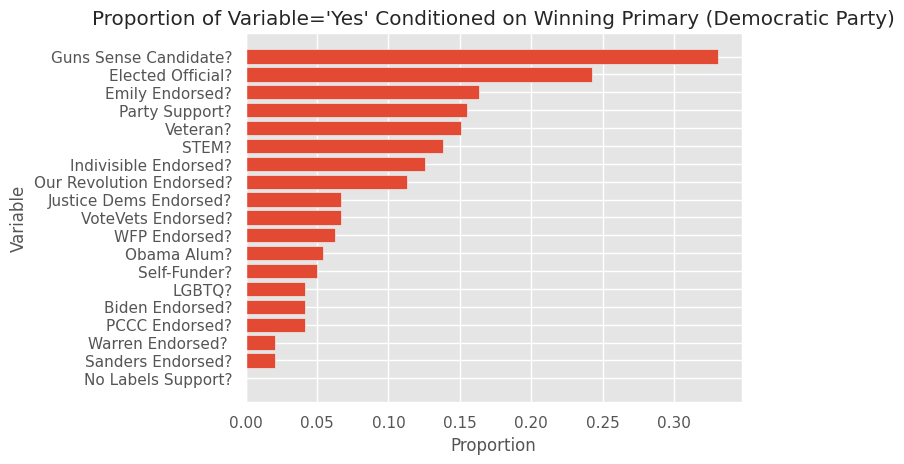

In [43]:
plt.barh('Variable', 'Proportion', data=dem_sorted)
plt.xlabel("Proportion")
plt.ylabel("Variable")
plt.title("Proportion of Variable='Yes' Conditioned on Winning Primary (Democratic Party)")
plt.show()

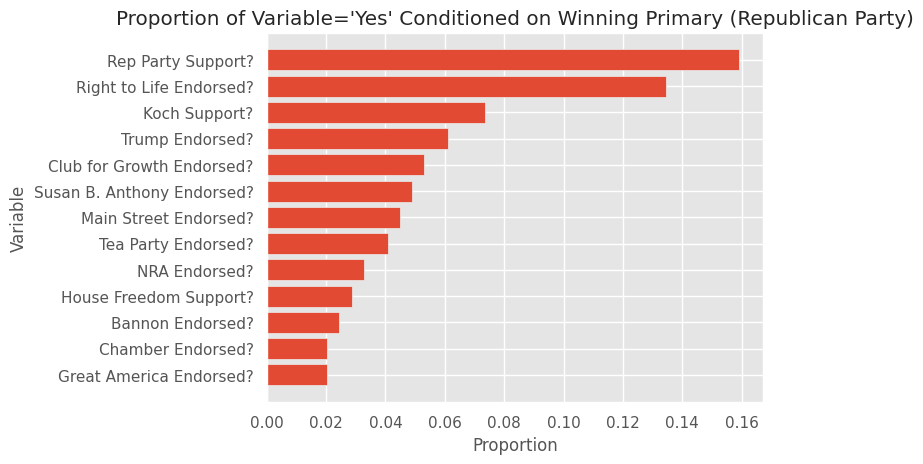

In [44]:
plt.barh('Variable', 'Proportion', data=rep_sorted)
plt.xlabel("Proportion")
plt.ylabel("Variable")
plt.title("Proportion of Variable='Yes' Conditioned on Winning Primary (Republican Party)")
plt.show()

These bar chart visualizations were constructed to compare binary (and thus categorical) variables for different support groups/individuals with the binary (and also categorical) variable for whether or not a candidate won their primary. They were constructed by binarizing the support variables into 0s ('No') and 1s ('Yes'), reducing the table down to only candidates that won their primary, finding the proportion of 1s for each support variable, sorting the support variables by these proportions, and finally plotting a bar chart. The variables with greater proportions indicate a greater number of 1s ('Yes') for that respective variable among candidates that won their primary.

The trends we observed were that for candidates who won their primary for the Democratic party, the variables that were most prevalent were being a guns sense candidate, elected official, and/or on EMILY's List (a roster produced by a political action committee whose goal is to elect Democratic female candidates in favor of abortion rights). For this same group of candidates, the variables that were least prevalent were being financially supported by a No Labels-affiliated group, endorsed by Bernie Sanders, and/or endorsed by Elizabeth Warren. For candidates who won their primary for the Republican party, the variables that were most prevalent were being supported by the Republic party (NRCC's Young Guns list, NRSC/RGA endorsement, financial expenditures from the Senate Leadership Fund or Congressional Leadership Fund), endorsed by the National Right to Life Committee, and/or financially supported by the Koch brothers. For this same group of candidates, the variables that were least prevalent were being endorsed by the Great America Alliance, endorsed by a state-level chamber of commerce, and/or endorsed by Steve Bannon. Some of these relationships that we may want to follow up on are why No Labels-affiliated groups appear to have little impact on Democratic primary winnings as well as the same for Bernie Sanders endorsements, especially when he was a candidate in the 2016 Democratic presidential primaries and would go on to win the same primaries in 2020. Additionally, we may want to follow up on why the aforementioned "prevalent" variables appeared in greater proportion among candidates who won their primary—is it because they actually impacted winning a primary or because they simply appeared more frequently than other variables (e.g. there are simply more elected officials than people endorsed by certain entities).

These visualizations are especially relevant to our first research question. More specifically, they suggest potential answers to whether or not the support of certain groups/individuals may cause a candidate to win their primary elections. As explained above, the bar charts indicate which variables were more or less common (proportionally) among candidates who won their primary elections. With this information, we may be able to deduce which variables cause a candidate to win or lose their primary. This may also be relevant to our second research question, which attempts to predict the percentage of votes a candidate will receive in their primary elections given the support of certain groups/individuals. Knowing which variables were more or less prevalent may impact their weights on our predictions. However, we know that visualizations and EDA as simple as the one conducted here will not suffice in answering our questions. As previously discussed, certain variables may be more prevalent than others simply because they appeared more frequently. We also do not know if there are any confounding variables that may impact a variable's effect on winning a primary. Thus, we must apply different causal inference techniques.

### Zayan

In [45]:
# Getting the number of candidates by state
rep_state_count = rep[['State']].value_counts().to_frame("Count").reset_index()
dem_state_count = dem[['State']].value_counts().to_frame("Count").reset_index()

In [46]:
# Creating a code to map the number of electoral votes by state
code = {'AL': 9,
        'AK': 3,
        'AZ': 11,
        'AR': 6,
        'CA': 55,
        'CO': 9,
        'CT': 7,
        'DE': 3,
        'DC': 3,
        'FL': 29,
        'GA': 16,
        'HI': 4,
        'ID': 4,
        'IL': 20,
        'IN': 11,
        'IA': 6,
        'KS': 6,
        'KY': 8,
        'LA': 8,
        'ME': 4,
        'MD': 10,
        'MA': 11,
        'MI': 16,
        'MN': 10,
        'MS': 6,
        'MO': 10,
        'MT': 3,
        'NE': 5,
        'NV': 6,
        'NH': 4,
        'NJ': 14,
        'NM': 5,
        'NY': 29,
        'NC': 15,
        'ND': 3,
        'OH': 18,
        'OK': 7,
        'OR': 7,
        'PA': 20,
        'RI': 4,
        'SC': 9,
        'SD': 3,
        'TN': 11,
        'TX': 38,
        'UT': 6,
        'VT': 3,
        'VA': 13,
        'WA': 12,
        'WV': 5,
        'WI': 10,
        'WY': 3}

In [47]:
rep_state_count['Electoral Votes'] = rep_state_count['State'].map(code)
dem_state_count['Electoral Votes'] = dem_state_count['State'].map(code)

In [48]:
rep_state_count['Ratio of Candidates to Electoral Votes'] = rep_state_count['Count'] / rep_state_count['Electoral Votes']
dem_state_count['Ratio of Candidates to Electoral Votes'] = dem_state_count['Count'] / rep_state_count['Electoral Votes']

In [49]:
# Next two plots are number of candidates by state
fig_r = px.choropleth(rep_state_count,
                    locations='State',
                    color='Count',
                    color_continuous_scale='spectral_r',
                    hover_name='State',
                    locationmode='USA-states',
                    labels={'Number of Republican Candidates'},
                    scope='usa')
fig_r.update_layout(
    title={'text':'Number of Republican Candidates by State',
           'xanchor':'center',
           'yanchor':'top',
           'x':0.5})
fig_r

In [50]:
fig_d = px.choropleth(dem_state_count,
                    locations='State',
                    color='Count',
                    color_continuous_scale='spectral_r',
                    hover_name='State',
                    locationmode='USA-states',
                    labels={'Number of Democratic Candidates'},
                    scope='usa')
fig_d.update_layout(
    title={'text':'Number of Democratic Candidates by State',
           'xanchor':'center',
           'yanchor':'top',
           'x':0.5})
fig_d

In [51]:
# The next two plots are the same information but is now normalized to be a ratio of electoral votes. 
# This is so larger states do not just dominate our visualization and we get a proportional visualization
fig_r_normalized = px.choropleth(rep_state_count,
                    locations='State',
                    color='Ratio of Candidates to Electoral Votes',
                    color_continuous_scale='spectral_r',
                    hover_name='State',
                    locationmode='USA-states',
                    labels={'Ratio of Republican Candidates to Electoral Votes'},
                    scope='usa')
fig_r_normalized.update_layout(
    title={'text':'Ratio of Republican Candidates to Electoral Votes by State',
           'xanchor':'center',
           'yanchor':'top',
           'x':0.5})
fig_r_normalized

In [52]:
fig_d_normalized = px.choropleth(dem_state_count,
                    locations='State',
                    color='Ratio of Candidates to Electoral Votes',
                    color_continuous_scale='spectral_r',
                    hover_name='State',
                    locationmode='USA-states',
                    labels={'Ratio of Democratic Candidates to Electoral Votes'},
                    scope='usa')
fig_d_normalized.update_layout(
    title={'text':'Ratio of Democratic Candidates to Electoral Votes by State',
           'xanchor':'center',
           'yanchor':'top',
           'x':0.5})
fig_d_normalized

I chose to visualize the number of candidates by state. I initially did the raw count, but I decided to add a normalized version, choosing to normalize by the number of electoral votes as a rough measure of population proportionality. 

These visualizations are important because they can help contextualize any trends we see in endorsements and make sure to control for any geographic associations. This also helps us get a better understanding of which states have more candidates running for those seats, because in races with more candidates, we hypothesize that endorsements have a larger impact on the outcome of the race. From these visualizations, I was intrigued that for Democratic candidates, the number of candidates seem to be similar across the Midwest and once again similar in the East Coast. I expect that this may be due to population, but interestingly enough this trend does not hold for Republican candidates. Another interesting trend was that for the normalized graphs, the states with the highest ratios were clustered near each other (Pacific Northwest for Republicans and Upper Midwest for Democrats). For next steps, I would want to explore if the number of endorsements or if certain endorsements occur for these specific clusters which are higher than other states.

# Research Question #1

Project Question 1: Does having the support of certain groups or individuals cause a candidate to win their primary elections? We will more formally define a list of support parties after cleaning the data.

We will be using the Chi Square test, which is used when we want to show a relationship between two categorical variables. We were originally going to use the McNemar's test, but our data violated the assumptions. 

### 1st Hypothesis Test

Null Hypothesis: There is no correlation between having the Democratic Party Support and winning the Democratic candidate's primary race. 

Alternate Hypothesis: There is a correlation between having the Democratic Party Support and winning the Democratic candidate's primary race. 

In [53]:
dem.groupby(['Won Primary', 'Party Support?']).count()

Candidate  State  District  Office Type   
Won Primary Party Support?                                            
0           0                     570    570       570          570  \
            1                       2      2         2            2   
1           0                     202    202       202          202   
            1                      37     37        37           37   

                            Race Primary Election Date  Partisan Lean   
Won Primary Party Support?                                              
0           0                                      570            570  \
            1                                        2              2   
1           0                                      202            202   
            1                                       37             37   

                            Primary %  Race  Veteran?  LGBTQ?  ...   
Won Primary Party Support?                                     ...   
0           0                     570   570       570     570  ...  \
            1                       2     2         2       2  ...   
1           0                     202   202       202     202  ...   
            1                      37    37        37      37  ...   

                            Warren Endorsed?   Sanders Endorsed?   
Won Primary Party Support?                                         
0           0                             570                570  \
            1                               2                  2   
1           0                             202                202   
            1                              37                 37   

                            Our Revolution Endorsed?  Justice Dems Endorsed?   
Won Primary Party Support?                                                     
0           0                                    570                     570  \
            1                                      2                       2   
1           0                                    202                     202   
            1                                     37                      37   

                            PCCC Endorsed?  Indivisible Endorsed?   
Won Primary Party Support?                                          
0           0                          570                    570  \
            1                            2                      2   
1           0                          202                    202   
            1                           37                     37   

                            WFP Endorsed?  VoteVets Endorsed?   
Won Primary Party Support?                                      
0           0                         570                 570  \
            1                           2                   2   
1           0                         202                 202   
            1                          37                  37   

                            No Labels Support?  number_of_candidates  
Won Primary Party Support?                                            
0           0                              570                   570  
            1                                2                     2  
1           0                              202                   202  
            1                               37                    37  

[4 rows x 27 columns]

In [54]:
firstdatatable = [[37, 202],[2, 570]]
c, p, dof, expected = chi2_contingency(firstdatatable)
p

2.2113425657148026e-19

### 2nd Hypothesis Test

Null Hypothesis: There is no correlation between having the Biden Endorsement and winning the Democratic candidate's primary race. 

Alternate Hypothesis: There is a correlation between having the Biden Endorsement and winning the Democratic candidate's primary race.  

In [55]:
dem.groupby(['Won Primary', 'Biden Endorsed?']).count()

Candidate  State  District  Office Type   
Won Primary Biden Endorsed?                                            
0           0                      572    572       572          572  \
1           0                      229    229       229          229   
            1                       10     10        10           10   

                             Race Primary Election Date  Partisan Lean   
Won Primary Biden Endorsed?                                              
0           0                                       572            572  \
1           0                                       229            229   
            1                                        10             10   

                             Primary %  Race  Veteran?  LGBTQ?  ...   
Won Primary Biden Endorsed?                                     ...   
0           0                      572   572       572     572  ...  \
1           0                      229   229       229     229  ...   
            1                       10    10        10      10  ...   

                             Warren Endorsed?   Sanders Endorsed?   
Won Primary Biden Endorsed?                                         
0           0                              572                572  \
1           0                              229                229   
            1                               10                 10   

                             Our Revolution Endorsed?  Justice Dems Endorsed?   
Won Primary Biden Endorsed?                                                     
0           0                                     572                     572  \
1           0                                     229                     229   
            1                                      10                      10   

                             PCCC Endorsed?  Indivisible Endorsed?   
Won Primary Biden Endorsed?                                          
0           0                           572                    572  \
1           0                           229                    229   
            1                            10                     10   

                             WFP Endorsed?  VoteVets Endorsed?   
Won Primary Biden Endorsed?                                      
0           0                          572                 572  \
1           0                          229                 229   
            1                           10                  10   

                             No Labels Support?  number_of_candidates  
Won Primary Biden Endorsed?                                            
0           0                               572                   572  
1           0                               229                   229  
            1                                10                    10  

[3 rows x 27 columns]

In [56]:
seconddatatable = [[10, 229],[0, 572]]
c, p, dof, expected = chi2_contingency(seconddatatable)
p

4.793800735599242e-06

### 3rd Hypothesis Test

Null Hypothesis: There is no correlation between being a Gun Sense Candidate and winning the Democratic candidate's primary race. 

Alternate Hypothesis: There is a correlation between being a Gun Sense Candidate and winning the Democratic candidate's primary race.  

In [57]:
dem.groupby(['Won Primary', 'Guns Sense Candidate?']).count()

Candidate  State  District  Office Type   
Won Primary Guns Sense Candidate?                                            
0           0                            458    458       458          458  \
            1                            114    114       114          114   
1           0                            160    160       160          160   
            1                             79     79        79           79   

                                   Race Primary Election Date  Partisan Lean   
Won Primary Guns Sense Candidate?                                              
0           0                                             458            458  \
            1                                             114            114   
1           0                                             160            160   
            1                                              79             79   

                                   Primary %  Race  Veteran?  LGBTQ?  ...   
Won Primary Guns Sense Candidate?                                     ...   
0           0                            458   458       458     458  ...  \
            1                            114   114       114     114  ...   
1           0                            160   160       160     160  ...   
            1                             79    79        79      79  ...   

                                   Warren Endorsed?   Sanders Endorsed?   
Won Primary Guns Sense Candidate?                                         
0           0                                    458                458  \
            1                                    114                114   
1           0                                    160                160   
            1                                     79                 79   

                                   Our Revolution Endorsed?   
Won Primary Guns Sense Candidate?                             
0           0                                           458  \
            1                                           114   
1           0                                           160   
            1                                            79   

                                   Justice Dems Endorsed?  PCCC Endorsed?   
Won Primary Guns Sense Candidate?                                           
0           0                                         458             458  \
            1                                         114             114   
1           0                                         160             160   
            1                                          79              79   

                                   Indivisible Endorsed?  WFP Endorsed?   
Won Primary Guns Sense Candidate?                                         
0           0                                        458            458  \
            1                                        114            114   
1           0                                        160            160   
            1                                         79             79   

                                   VoteVets Endorsed?  No Labels Support?   
Won Primary Guns Sense Candidate?                                           
0           0                                     458                 458  \
            1                                     114                 114   
1           0                                     160                 160   
            1                                      79                  79   

                                   number_of_candidates  
Won Primary Guns Sense Candidate?                        
0           0                                       458  
            1                                       114  
1           0                                       160  
            1                                        79  

[4 rows x 27 columns]

In [58]:
thirddatatable = [[79, 160],[114, 458]]
c, p, dof, expected = chi2_contingency(thirddatatable)
p

9.192960128852962e-05

### 4th Hypothesis Test

Null Hypothesis: There is no correlation between being an Elected Official and winning the Democratic candidate's primary race. 

Alternate Hypothesis: There is some correlation between being an Elected Official and winning the Democratic candidate's primary race. 

In [59]:
dem.groupby(['Won Primary', 'Elected Official?']).count()

Candidate  State  District  Office Type   
Won Primary Elected Official?                                            
0           0                        497    497       497          497  \
            1                         75     75        75           75   
1           0                        181    181       181          181   
            1                         58     58        58           58   

                               Race Primary Election Date  Partisan Lean   
Won Primary Elected Official?                                              
0           0                                         497            497  \
            1                                          75             75   
1           0                                         181            181   
            1                                          58             58   

                               Primary %  Race  Veteran?  LGBTQ?  ...   
Won Primary Elected Official?                                     ...   
0           0                        497   497       497     497  ...  \
            1                         75    75        75      75  ...   
1           0                        181   181       181     181  ...   
            1                         58    58        58      58  ...   

                               Warren Endorsed?   Sanders Endorsed?   
Won Primary Elected Official?                                         
0           0                                497                497  \
            1                                 75                 75   
1           0                                181                181   
            1                                 58                 58   

                               Our Revolution Endorsed?   
Won Primary Elected Official?                             
0           0                                       497  \
            1                                        75   
1           0                                       181   
            1                                        58   

                               Justice Dems Endorsed?  PCCC Endorsed?   
Won Primary Elected Official?                                           
0           0                                     497             497  \
            1                                      75              75   
1           0                                     181             181   
            1                                      58              58   

                               Indivisible Endorsed?  WFP Endorsed?   
Won Primary Elected Official?                                         
0           0                                    497            497  \
            1                                     75             75   
1           0                                    181            181   
            1                                     58             58   

                               VoteVets Endorsed?  No Labels Support?   
Won Primary Elected Official?                                           
0           0                                 497                 497  \
            1                                  75                  75   
1           0                                 181                 181   
            1                                  58                  58   

                               number_of_candidates  
Won Primary Elected Official?                        
0           0                                   497  
            1                                    75  
1           0                                   181  
            1                                    58  

[4 rows x 27 columns]

In [60]:
fourthdatatable = [[58, 181],[75, 497]]
c, p, dof, expected = chi2_contingency(fourthdatatable)
p

0.0001402409285149926

### 5th Hypothesis Test

Null Hypothesis: There is no correlation between being endorsed by Emily and winning the Democratic candidate's primary race. 

Alternate Hypothesis: There is some correlation between being endorsed by Emily and winning the Democratic candidate's primary race. 

In [61]:
dem.groupby(['Won Primary', 'Emily Endorsed?']).count()

Candidate  State  District  Office Type   
Won Primary Emily Endorsed?                                            
0           0                      557    557       557          557  \
            1                       15     15        15           15   
1           0                      200    200       200          200   
            1                       39     39        39           39   

                             Race Primary Election Date  Partisan Lean   
Won Primary Emily Endorsed?                                              
0           0                                       557            557  \
            1                                        15             15   
1           0                                       200            200   
            1                                        39             39   

                             Primary %  Race  Veteran?  LGBTQ?  ...   
Won Primary Emily Endorsed?                                     ...   
0           0                      557   557       557     557  ...  \
            1                       15    15        15      15  ...   
1           0                      200   200       200     200  ...   
            1                       39    39        39      39  ...   

                             Warren Endorsed?   Sanders Endorsed?   
Won Primary Emily Endorsed?                                         
0           0                              557                557  \
            1                               15                 15   
1           0                              200                200   
            1                               39                 39   

                             Our Revolution Endorsed?  Justice Dems Endorsed?   
Won Primary Emily Endorsed?                                                     
0           0                                     557                     557  \
            1                                      15                      15   
1           0                                     200                     200   
            1                                      39                      39   

                             PCCC Endorsed?  Indivisible Endorsed?   
Won Primary Emily Endorsed?                                          
0           0                           557                    557  \
            1                            15                     15   
1           0                           200                    200   
            1                            39                     39   

                             WFP Endorsed?  VoteVets Endorsed?   
Won Primary Emily Endorsed?                                      
0           0                          557                 557  \
            1                           15                  15   
1           0                          200                 200   
            1                           39                  39   

                             No Labels Support?  number_of_candidates  
Won Primary Emily Endorsed?                                            
0           0                               557                   557  
            1                                15                    15  
1           0                               200                   200  
            1                                39                    39  

[4 rows x 27 columns]

In [62]:
fifthdatatable = [[39, 200],[15, 557]]
c, p, dof, expected = chi2_contingency(fifthdatatable)
p

2.9927894265018166e-12

### 6th Hypothesis Test

Null Hypothesis: There is no correlation between being white and winning the Democratic candidate's primary race. 

AlternateHypothesis: There is some correlation between being white and winning the Democratic candidate's primary race. 

In [63]:
#if race = 0, it means the candidate's race is unknown. Therefore, we will exclude it. 
dem.groupby(['Won Primary', 'Race']).count()

Candidate  State  District  Office Type   
Won Primary Race                                                
0           0               118    118       118          118  \
            Nonwhite        147    147       147          147   
            White           307    307       307          307   
1           0                38     38        38           38   
            Nonwhite         56     56        56           56   
            White           145    145       145          145   

                      Race Primary Election Date  Partisan Lean  Primary %   
Won Primary Race                                                             
0           0                                118            118        118  \
            Nonwhite                         147            147        147   
            White                            307            307        307   
1           0                                 38             38         38   
            Nonwhite                          56             56         56   
            White                            145            145        145   

                      Veteran?  LGBTQ?  Elected Official?  ...   
Won Primary Race                                           ...   
0           0              118     118                118  ...  \
            Nonwhite       147     147                147  ...   
            White          307     307                307  ...   
1           0               38      38                 38  ...   
            Nonwhite        56      56                 56  ...   
            White          145     145                145  ...   

                      Warren Endorsed?   Sanders Endorsed?   
Won Primary Race                                             
0           0                       118                118  \
            Nonwhite                147                147   
            White                   307                307   
1           0                        38                 38   
            Nonwhite                 56                 56   
            White                   145                145   

                      Our Revolution Endorsed?  Justice Dems Endorsed?   
Won Primary Race                                                         
0           0                              118                     118  \
            Nonwhite                       147                     147   
            White                          307                     307   
1           0                               38                      38   
            Nonwhite                        56                      56   
            White                          145                     145   

                      PCCC Endorsed?  Indivisible Endorsed?  WFP Endorsed?   
Won Primary Race                                                             
0           0                    118                    118            118  \
            Nonwhite             147                    147            147   
            White                307                    307            307   
1           0                     38                     38             38   
            Nonwhite              56                     56             56   
            White                145                    145            145   

                      VoteVets Endorsed?  No Labels Support?   
Won Primary Race                                               
0           0                        118                 118  \
            Nonwhite                 147                 147   
            White                    307                 307   
1           0                         38                  38   
            Nonwhite                  56                  56   
            White                    145                 145   

                      number_of_candidates  
Won Primary Race                            
0           0                

In [64]:
sixthdatatable = [[145, 56],[307, 147]]
c, p, dof, expected = chi2_contingency(sixthdatatable)
p

0.2884333620602043

### 7th Hypothesis Test

Null Hypothesis: There is no correlation between being endorsed by Our Revolution and winning the Democratic candidate's primary race. 

Alternate Hypothesis: There is some correlation between being endorsed by Our Revolution and winning the Democratic candidate's primary race. 

In [65]:
dem.groupby(['Won Primary', 'Our Revolution Endorsed?']).count()

Candidate  State  District  Office Type   
Won Primary Our Revolution Endorsed?                                            
0           0                               514    514       514          514  \
            1                                58     58        58           58   
1           0                               212    212       212          212   
            1                                27     27        27           27   

                                      Race Primary Election Date   
Won Primary Our Revolution Endorsed?                               
0           0                                                514  \
            1                                                 58   
1           0                                                212   
            1                                                 27   

                                      Partisan Lean  Primary %  Race   
Won Primary Our Revolution Endorsed?                                   
0           0                                   514        514   514  \
            1                                    58         58    58   
1           0                                   212        212   212   
            1                                    27         27    27   

                                      Veteran?  LGBTQ?  ...  Biden Endorsed?   
Won Primary Our Revolution Endorsed?                    ...                    
0           0                              514     514  ...              514  \
            1                               58      58  ...               58   
1           0                              212     212  ...              212   
            1                               27      27  ...               27   

                                      Warren Endorsed?   Sanders Endorsed?   
Won Primary Our Revolution Endorsed?                                         
0           0                                       514                514  \
            1                                        58                 58   
1           0                                       212                212   
            1                                        27                 27   

                                      Justice Dems Endorsed?  PCCC Endorsed?   
Won Primary Our Revolution Endorsed?                                           
0           0                                            514             514  \
            1                                             58              58   
1           0                                            212             212   
            1                                             27              27   

                                      Indivisible Endorsed?  WFP Endorsed?   
Won Primary Our Revolution Endorsed?                                         
0           0                                           514            514  \
            1                                            58             58   
1           0                                           212            212   
            1                                            27             27   

                                      VoteVets Endorsed?  No Labels Support?   
Won Primary Our Revolution Endorsed?                                           
0           0                                        514                 514  \
            1                                         58                  58   
1           0                                        212                 212   
            1                                         27                  27   

                                      number_of_candidates  
Won Primary Our Revolution Endorsed?                        
0           0                                          514  
            1                                           58  
1           0                                          212  
            1          

In [66]:
seventhdatatable = [[27, 212],[58, 514]]
c, p, dof, expected = chi2_contingency(seventhdatatable)
p

0.7152777665289085

### 8th Hypothesis Test

Null Hypothesis: There is no correlation between being endorsed by PCCC and winning the Democratic candidate's primary race. 

Alternate Hypothesis: There is some correlation between being endorsed by PCCC and winning the Democratic candidate's primary race. 

In [67]:
dem.groupby(['Won Primary', 'PCCC Endorsed?']).count()

Candidate  State  District  Office Type   
Won Primary PCCC Endorsed?                                            
0           0                     567    567       567          567  \
            1                       5      5         5            5   
1           0                     229    229       229          229   
            1                      10     10        10           10   

                            Race Primary Election Date  Partisan Lean   
Won Primary PCCC Endorsed?                                              
0           0                                      567            567  \
            1                                        5              5   
1           0                                      229            229   
            1                                       10             10   

                            Primary %  Race  Veteran?  LGBTQ?  ...   
Won Primary PCCC Endorsed?                                     ...   
0           0                     567   567       567     567  ...  \
            1                       5     5         5       5  ...   
1           0                     229   229       229     229  ...   
            1                      10    10        10      10  ...   

                            Biden Endorsed?  Warren Endorsed?    
Won Primary PCCC Endorsed?                                       
0           0                           567                567  \
            1                             5                  5   
1           0                           229                229   
            1                            10                 10   

                            Sanders Endorsed?  Our Revolution Endorsed?   
Won Primary PCCC Endorsed?                                                
0           0                             567                       567  \
            1                               5                         5   
1           0                             229                       229   
            1                              10                        10   

                            Justice Dems Endorsed?  Indivisible Endorsed?   
Won Primary PCCC Endorsed?                                                  
0           0                                  567                    567  \
            1                                    5                      5   
1           0                                  229                    229   
            1                                   10                     10   

                            WFP Endorsed?  VoteVets Endorsed?   
Won Primary PCCC Endorsed?                                      
0           0                         567                 567  \
            1                           5                   5   
1           0                         229                 229   
            1                          10                  10   

                            No Labels Support?  number_of_candidates  
Won Primary PCCC Endorsed?                                            
0           0                              567                   567  
            1                                5                     5  
1           0                              229                   229  
            1                               10                    10  

[4 rows x 27 columns]

In [68]:
eigthdatatable = [[10, 229],[5, 567]]
c, p, dof, expected = chi2_contingency(eigthdatatable)
p

0.003687493621225876

In [69]:
#calculate through phi()
effect_size = np.sqrt(c / 811)
print('power: %.4f' % power_chi2(dof=1, w=effect_size, n=811, alpha = .05))

power: 0.8274


### Bonferroni Correction

In [70]:
def bonferroni(p_values, alpha_total):
    """
    Returns decisions on p-values using the Bonferroni correction.
    
    Inputs:
        p_values: array of p-values
        alpha_total: desired family-wise error rate (FWER = P(at least one false discovery))
    
    Returns:
        decisions: binary array of same length as p-values, where `decisions[i]` is 1
        if `p_values[i]` is deemed significant, and 0 otherwise
    """
    
    decisions = p_values < (alpha_total / np.size(p_values))
    return decisions

In [71]:
p_values = np. array([2.21134257e-19, 2.99278943e-12, 4.79380074e-06, 9.19296013e-05,1.40240929e-04, 3.68749362e-03, 2.88433362e-01, 7.15277767e-01])
bonferroni(p_values, .05)

array([ True,  True,  True,  True,  True,  True, False, False])

### Benjamin Hocherg Correction

In [72]:
def benjamini_hochberg(p_values, alpha):
    """
    Returns decisions on p-values using Benjamini-Hochberg.
    
    Inputs:
        p_values: array of p-values
        alpha: desired FDR (FDR = E[# false positives / # positives])
    
    Returns:
        decisions: binary array of same length as p-values, where `decisions[i]` is 1
        if `p_values[i]` is deemed significant, and 0 otherwise
    """
    length = np.size(p_values)
    bh_factor = np.arange(1, length + 1) * (alpha / length)
    index = 0
    p_values_sorted = np.sort(p_values)
    for i in np.arange(np.size(p_values)):
        if p_values_sorted[i] < bh_factor[i]:
            index = i
    decisions = p_values < p_values_sorted[index + 1]
    return decisions

In [73]:
benjamini_hochberg(p_values, .05)

array([ True,  True,  True,  True,  True,  True, False, False])

### Causal Inference

In [74]:
# Confounders: veteran is confounded to getting a Vote Vet Endorsement and winning
    # Obama alum -> biden endorsed
    # Obama alum -> democratic party support


In [75]:
#from lab
def fit_OLS_model(df, target_variable, explanatory_variables, intercept = False):
    """
    Fits an OLS model from data.
    
    Inputs:
        df: pandas DataFrame
        target_variable: string, name of the target variable
        explanatory_variables: list of strings, names of the explanatory variables
        intercept: bool, if True add intercept term
    Outputs:
        fitted_model: model containing OLS regression results
    """
    
    target = df[target_variable]
    inputs = df[explanatory_variables]
    if intercept:
        inputs = sm.add_constant(inputs)
    
    fitted_model = sm.OLS(target, inputs).fit()
    return(fitted_model)

In [76]:
#naive ols
dem_party_support = fit_OLS_model(dem, 'Won Primary', ["Party Support?"])
print(dem_party_support.summary())

                                 OLS Regression Results                                
Dep. Variable:            Won Primary   R-squared (uncentered):                   0.147
Model:                            OLS   Adj. R-squared (uncentered):              0.146
Method:                 Least Squares   F-statistic:                              139.4
Date:                Tue, 09 May 2023   Prob (F-statistic):                    8.35e-30
Time:                        06:23:59   Log-Likelihood:                         -590.91
No. Observations:                 811   AIC:                                      1184.
Df Residuals:                     810   BIC:                                      1189.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

In [77]:
# Looking at how support from the Democratic Party is associated with whether the candidate
# won their primary
dem_party_support = fit_OLS_model(dem, 'Won Primary', ["Party Support?", 'Biden Endorsed?', 'Guns Sense Candidate?', 'Elected Official?', 'Emily Endorsed?', 'Our Revolution Endorsed?', 'PCCC Endorsed?'])
print(dem_party_support.summary())

                                 OLS Regression Results                                
Dep. Variable:            Won Primary   R-squared (uncentered):                   0.313
Model:                            OLS   Adj. R-squared (uncentered):              0.307
Method:                 Least Squares   F-statistic:                              52.35
Date:                Tue, 09 May 2023   Prob (F-statistic):                    1.49e-61
Time:                        06:23:59   Log-Likelihood:                         -503.03
No. Observations:                 811   AIC:                                      1020.
Df Residuals:                     804   BIC:                                      1053.
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                               coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

In [78]:
dem_party_support_params = dem_party_support.params
dem_party_support_params

Party Support?              0.575196
Biden Endorsed?             0.220910
Guns Sense Candidate?       0.246274
Elected Official?           0.251825
Emily Endorsed?             0.295553
Our Revolution Endorsed?    0.134502
PCCC Endorsed?              0.211722
dtype: float64

In [79]:
dem_domain_knowledge = fit_OLS_model(dem, 'Won Primary', ["Party Support?", "Obama Alum?", "Emily Endorsed?", "Biden Endorsed?", "Warren Endorsed? ", "Sanders Endorsed?", "Guns Sense Candidate?"])
print(dem_domain_knowledge.summary())

                                 OLS Regression Results                                
Dep. Variable:            Won Primary   R-squared (uncentered):                   0.275
Model:                            OLS   Adj. R-squared (uncentered):              0.269
Method:                 Least Squares   F-statistic:                              43.61
Date:                Tue, 09 May 2023   Prob (F-statistic):                    2.58e-52
Time:                        06:23:59   Log-Likelihood:                         -524.81
No. Observations:                 811   AIC:                                      1064.
Df Residuals:                     804   BIC:                                      1097.
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

In [80]:
dem_domain_knowledge_params = dem_domain_knowledge.params
dem_domain_knowledge_params

Party Support?           0.592537
Obama Alum?              0.089559
Emily Endorsed?          0.335598
Biden Endorsed?          0.271302
Warren Endorsed?         0.260768
Sanders Endorsed?        0.374980
Guns Sense Candidate?    0.300006
dtype: float64

In [81]:
dem_combined_support = fit_OLS_model(dem, 'Won Primary', ["Party Support?", 'Biden Endorsed?', 'Guns Sense Candidate?', 'Elected Official?', 'Our Revolution Endorsed?', "Obama Alum?", "Emily Endorsed?", "Warren Endorsed? ", "Sanders Endorsed?"])
print(dem_combined_support.summary())

                                 OLS Regression Results                                
Dep. Variable:            Won Primary   R-squared (uncentered):                   0.315
Model:                            OLS   Adj. R-squared (uncentered):              0.308
Method:                 Least Squares   F-statistic:                              41.03
Date:                Tue, 09 May 2023   Prob (F-statistic):                    2.22e-60
Time:                        06:23:59   Log-Likelihood:                         -501.73
No. Observations:                 811   AIC:                                      1021.
Df Residuals:                     802   BIC:                                      1064.
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
                               coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

# Research Question #2

What percentage of votes will a candidate receive in their primary elections with the support(s) of  _____? We will fill in the blank with a list of support parties after cleaning the data and analyzing the results from our models.

### Frequentist GLM (Dem)

In [82]:
train, test = train_test_split(dem, test_size = .3, random_state = 101)

In [83]:
x_var = ['Veteran?', 'LGBTQ?', 'Elected Official?',
       'Self-Funder?', 'STEM?', 'Obama Alum?', 'Party Support?',
       'Emily Endorsed?', 'Guns Sense Candidate?', 'Biden Endorsed?',
       'Warren Endorsed? ', 'Sanders Endorsed?', 'Our Revolution Endorsed?',
       'Justice Dems Endorsed?', 'PCCC Endorsed?', 'Indivisible Endorsed?',
       'WFP Endorsed?', 'VoteVets Endorsed?', 'No Labels Support?',
       'number_of_candidates']

In [84]:
#Poisson

In [85]:
dem_poisson_model = sm.GLM(train['Primary %'], exog = sm.add_constant(train[x_var]), 
                  family=sm.families.Poisson())
dem_poisson_res = dem_poisson_model.fit()
print(dem_poisson_res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Primary %   No. Observations:                  567
Model:                            GLM   Df Residuals:                      546
Model Family:                 Poisson   Df Model:                           20
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4562.4
Date:                Tue, 09 May 2023   Deviance:                       6451.7
Time:                        06:23:59   Pearson chi2:                 6.45e+03
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [86]:
#remove variables with p-values > 0.05
dem_poisson_model = sm.GLM(train['Primary %'], exog = sm.add_constant(train[['Veteran?', 'Elected Official?',
       'Self-Funder?', 'STEM?', 'Obama Alum?', 'Party Support?',
       'Emily Endorsed?', 'Guns Sense Candidate?', 'Biden Endorsed?',
       'Warren Endorsed? ', 'Sanders Endorsed?', 'Our Revolution Endorsed?',
       'Justice Dems Endorsed?', 'Indivisible Endorsed?', 'VoteVets Endorsed?', 'No Labels Support?',
       'number_of_candidates']]), 
                  family=sm.families.Poisson())
dem_poisson_res = dem_poisson_model.fit()
print(dem_poisson_res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Primary %   No. Observations:                  567
Model:                            GLM   Df Residuals:                      549
Model Family:                 Poisson   Df Model:                           17
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4563.0
Date:                Tue, 09 May 2023   Deviance:                       6452.8
Time:                        06:23:59   Pearson chi2:                 6.44e+03
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [87]:
dem_poisson_train_pred = dem_poisson_res.predict(sm.add_constant(train[['Veteran?', 'Elected Official?',
       'Self-Funder?', 'STEM?', 'Obama Alum?', 'Party Support?',
       'Emily Endorsed?', 'Guns Sense Candidate?', 'Biden Endorsed?',
       'Warren Endorsed? ', 'Sanders Endorsed?', 'Our Revolution Endorsed?',
       'Justice Dems Endorsed?', 'Indivisible Endorsed?',
        'VoteVets Endorsed?', 'No Labels Support?',
       'number_of_candidates']].to_numpy()))
dem_poisson_test_pred = dem_poisson_res.predict(sm.add_constant(test[['Veteran?', 'Elected Official?',
       'Self-Funder?', 'STEM?', 'Obama Alum?', 'Party Support?',
       'Emily Endorsed?', 'Guns Sense Candidate?', 'Biden Endorsed?',
       'Warren Endorsed? ', 'Sanders Endorsed?', 'Our Revolution Endorsed?',
       'Justice Dems Endorsed?', 'Indivisible Endorsed?',
        'VoteVets Endorsed?', 'No Labels Support?',
       'number_of_candidates']].to_numpy()))
dem_train_rmse = np.mean((dem_poisson_train_pred - train['Primary %']) ** 2) ** 0.5
dem_test_rmse = np.mean((dem_poisson_test_pred - test['Primary %']) ** 2) ** 0.5
print("Democrat Train RMSE (Poisson):")
print(dem_train_rmse)
print("Democrat Test RMSE (Poisson):")
print(dem_test_rmse)

Democrat Train RMSE (Poisson):
18.745660245133102
Democrat Test RMSE (Poisson):
16.51544274419944


In [88]:
#Gaussian

In [89]:
dem_gaussian_model = sm.GLM(train['Primary %'], exog = sm.add_constant(train[x_var]), 
                  family=sm.families.Gaussian())
dem_gaussian_res = dem_gaussian_model.fit()
print(dem_gaussian_res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Primary %   No. Observations:                  567
Model:                            GLM   Df Residuals:                      546
Model Family:                Gaussian   Df Model:                           20
Link Function:               Identity   Scale:                          396.20
Method:                          IRLS   Log-Likelihood:                -2489.7
Date:                Tue, 09 May 2023   Deviance:                   2.1632e+05
Time:                        06:23:59   Pearson chi2:                 2.16e+05
No. Iterations:                     3   Pseudo R-squ. (CS):             0.5459
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [90]:
#remove variables with p-values > 0.05
dem_gaussian_model = sm.GLM(train['Primary %'], exog = sm.add_constant(train[['Elected Official?', 
        'Party Support?', 'Biden Endorsed?', 
        'Indivisible Endorsed?','number_of_candidates']]), 
                  family=sm.families.Gaussian())
dem_gaussian_res = dem_gaussian_model.fit()
print(dem_gaussian_res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Primary %   No. Observations:                  567
Model:                            GLM   Df Residuals:                      561
Model Family:                Gaussian   Df Model:                            5
Link Function:               Identity   Scale:                          405.83
Method:                          IRLS   Log-Likelihood:                -2504.2
Date:                Tue, 09 May 2023   Deviance:                   2.2767e+05
Time:                        06:24:00   Pearson chi2:                 2.28e+05
No. Iterations:                     3   Pseudo R-squ. (CS):             0.5136
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    52.58

In [91]:
dem_gaussian_train_pred = dem_gaussian_res.predict(sm.add_constant(train[['Elected Official?', 
        'Party Support?', 'Biden Endorsed?', 
        'Indivisible Endorsed?','number_of_candidates']].to_numpy()))
dem_gaussian_test_pred = dem_gaussian_res.predict(sm.add_constant(test[['Elected Official?', 
        'Party Support?', 'Biden Endorsed?', 
        'Indivisible Endorsed?','number_of_candidates']].to_numpy()))
dem_train_rmse = np.mean((dem_gaussian_train_pred - train['Primary %']) ** 2) ** 0.5
dem_test_rmse = np.mean((dem_gaussian_test_pred - test['Primary %']) ** 2) ** 0.5
print("Democrat Train RMSE (Gaussian):")
print(dem_train_rmse)
print("Democrat Test RMSE (Gaussian):")
print(dem_test_rmse)

Democrat Train RMSE (Gaussian):
20.03832131292343
Democrat Test RMSE (Gaussian):
18.811531598810394


In [92]:
#Negative Binomial

In [93]:
dem_negbin_model = sm.GLM(train['Primary %'], exog = sm.add_constant(train[x_var]), 
                  family=sm.families.NegativeBinomial())
dem_negbin_res = dem_negbin_model.fit()
print(dem_negbin_res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Primary %   No. Observations:                  567
Model:                            GLM   Df Residuals:                      546
Model Family:        NegativeBinomial   Df Model:                           20
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2400.5
Date:                Tue, 09 May 2023   Deviance:                       353.54
Time:                        06:24:00   Pearson chi2:                     272.
No. Iterations:                    14   Pseudo R-squ. (CS):             0.3061
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [94]:
#remove variables with p-values > 0.05
dem_negbin_model = sm.GLM(train['Primary %'], exog = sm.add_constant(train[['Elected Official?',
        'Guns Sense Candidate?', 'number_of_candidates']]), 
                  family=sm.families.NegativeBinomial())
dem_negbin_res = dem_negbin_model.fit()
print(dem_negbin_res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Primary %   No. Observations:                  567
Model:                            GLM   Df Residuals:                      563
Model Family:        NegativeBinomial   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2419.6
Date:                Tue, 09 May 2023   Deviance:                       391.90
Time:                        06:24:00   Pearson chi2:                     304.
No. Iterations:                    12   Pseudo R-squ. (CS):             0.2575
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     4.04

In [95]:
dem_negbin_train_pred = dem_negbin_res.predict(sm.add_constant(train[['Elected Official?',
        'Guns Sense Candidate?', 'number_of_candidates']].to_numpy()))
dem_negbin_test_pred = dem_negbin_res.predict(sm.add_constant(test[['Elected Official?',
        'Guns Sense Candidate?', 'number_of_candidates']].to_numpy()))
dem_train_rmse = np.mean((dem_negbin_train_pred - train['Primary %']) ** 2) ** 0.5
dem_test_rmse = np.mean((dem_negbin_test_pred - test['Primary %']) ** 2) ** 0.5
print("Democrat Train RMSE (Negative Binomial):")
print(dem_train_rmse)
print("Democrat Test RMSE (Negative Binomial):")
print(dem_test_rmse)

Democrat Train RMSE (Negative Binomial):
20.85645787312579
Democrat Test RMSE (Negative Binomial):
18.665368330387306


## Frequentist GLM (Rep)

In [96]:
train, test = train_test_split(rep, test_size = .3, random_state = 101)

In [97]:
x_var = ['Rep Party Support?',
       'Trump Endorsed?', 'Bannon Endorsed?', 'Great America Endorsed?',
       'NRA Endorsed?', 'Right to Life Endorsed?',
       'Susan B. Anthony Endorsed?', 'Club for Growth Endorsed?',
       'Koch Support?', 'House Freedom Support?', 'Tea Party Endorsed?',
       'Main Street Endorsed?', 'Chamber Endorsed?', 'number_of_candidates']

In [98]:
#Poisson

In [99]:
rep_poisson_model = sm.GLM(train['Primary %'], exog = sm.add_constant(train[x_var]), 
                  family=sm.families.Poisson())
rep_poisson_res = rep_poisson_model.fit()
print(rep_poisson_res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Primary %   No. Observations:                  541
Model:                            GLM   Df Residuals:                      526
Model Family:                 Poisson   Df Model:                           14
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -9491.8
Date:                Tue, 09 May 2023   Deviance:                       16501.
Time:                        06:24:00   Pearson chi2:                 1.77e+04
No. Iterations:                     5   Pseudo R-squ. (CS):             0.7506
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [100]:
#remove variables with p-values > 0.05
rep_poisson_model = sm.GLM(train['Primary %'], exog = sm.add_constant(train[['Rep Party Support?',
       'Trump Endorsed?', 'Bannon Endorsed?', 'Right to Life Endorsed?',
       'Susan B. Anthony Endorsed?', 'Club for Growth Endorsed?',
       'Koch Support?', 'Tea Party Endorsed?',
       'Main Street Endorsed?', 'Chamber Endorsed?']]), 
                  family=sm.families.Poisson())
rep_poisson_res = rep_poisson_model.fit()
print(rep_poisson_res.summary())

In [101]:
rep_poisson_train_pred = rep_poisson_res.predict(sm.add_constant(train[['Rep Party Support?',
       'Trump Endorsed?', 'Bannon Endorsed?', 'Right to Life Endorsed?',
       'Susan B. Anthony Endorsed?', 'Club for Growth Endorsed?',
       'Koch Support?', 'Tea Party Endorsed?',
       'Main Street Endorsed?', 'Chamber Endorsed?']].to_numpy()))
rep_poisson_test_pred = rep_poisson_res.predict(sm.add_constant(test[['Rep Party Support?',
       'Trump Endorsed?', 'Bannon Endorsed?', 'Right to Life Endorsed?',
       'Susan B. Anthony Endorsed?', 'Club for Growth Endorsed?',
       'Koch Support?', 'Tea Party Endorsed?',
       'Main Street Endorsed?', 'Chamber Endorsed?']].to_numpy()))
rep_train_rmse = np.mean((rep_poisson_train_pred - train['Primary %']) ** 2) ** 0.5
rep_test_rmse = np.mean((rep_poisson_test_pred - test['Primary %']) ** 2) ** 0.5
print("Republican Train RMSE (Poisson):")
print(rep_train_rmse)
print("Republican Test RMSE (Poisson):")
print(rep_test_rmse)

In [102]:
#Gaussian

In [103]:
rep_gaussian_model = sm.GLM(train['Primary %'], exog = sm.add_constant(train[x_var]), 
                  family=sm.families.Gaussian())
rep_gaussian_res = rep_gaussian_model.fit()
print(rep_gaussian_res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Primary %   No. Observations:                  541
Model:                            GLM   Df Residuals:                      526
Model Family:                Gaussian   Df Model:                           14
Link Function:               Identity   Scale:                          1048.4
Method:                          IRLS   Log-Likelihood:                -2641.4
Date:                Tue, 09 May 2023   Deviance:                   5.5145e+05
Time:                        06:24:00   Pearson chi2:                 5.51e+05
No. Iterations:                     3   Pseudo R-squ. (CS):            0.05166
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [104]:
#remove variables with p-values > 0.05
rep_gaussian_model = sm.GLM(train['Primary %'], exog = sm.add_constant(train[['Rep Party Support?',
       'Club for Growth Endorsed?']]), 
                  family=sm.families.Gaussian())
rep_gaussian_res = rep_gaussian_model.fit()
print(rep_gaussian_res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Primary %   No. Observations:                  541
Model:                            GLM   Df Residuals:                      538
Model Family:                Gaussian   Df Model:                            2
Link Function:               Identity   Scale:                          1044.1
Method:                          IRLS   Log-Likelihood:                -2646.4
Date:                Tue, 09 May 2023   Deviance:                   5.6172e+05
Time:                        06:24:00   Pearson chi2:                 5.62e+05
No. Iterations:                     3   Pseudo R-squ. (CS):            0.03412
Covariance Type:            nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [105]:
rep_gaussian_train_pred = rep_gaussian_res.predict(sm.add_constant(train[['Rep Party Support?',
       'Club for Growth Endorsed?']]).to_numpy())
rep_gaussian_test_pred = rep_gaussian_res.predict(sm.add_constant(test[['Rep Party Support?',
       'Club for Growth Endorsed?']]).to_numpy())
rep_train_rmse = np.mean((rep_gaussian_train_pred - train['Primary %']) ** 2) ** 0.5
rep_test_rmse = np.mean((rep_gaussian_test_pred - test['Primary %']) ** 2) ** 0.5
print("Republican Train RMSE (Gaussian):")
print(rep_train_rmse)
print("Republican Test RMSE (Gaussian):")
print(rep_test_rmse)

Republican Train RMSE (Gaussian):
32.22259051207842
Republican Test RMSE (Gaussian):
30.55487403557254


In [106]:
#Negative Binomial

In [107]:
rep_negbin_model = sm.GLM(train['Primary %'], exog = sm.add_constant(train[x_var]), 
                  family=sm.families.NegativeBinomial())
rep_negbin_res = rep_negbin_model.fit()
print(rep_negbin_res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Primary %   No. Observations:                  541
Model:                            GLM   Df Residuals:                      526
Model Family:        NegativeBinomial   Df Model:                           14
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2427.1
Date:                Tue, 09 May 2023   Deviance:                       736.63
Time:                        06:24:00   Pearson chi2:                     559.
No. Iterations:                    21   Pseudo R-squ. (CS):            0.03563
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [108]:
#remove variables with p-values > 0.05
rep_negbin_model = sm.GLM(train['Primary %'], exog = sm.add_constant(train[['Rep Party Support?']]), 
                  family=sm.families.NegativeBinomial())
rep_negbin_res = rep_negbin_model.fit()
print(rep_negbin_res.summary())

In [109]:
rep_negbin_train_pred = rep_negbin_res.predict(sm.add_constant(train[['Rep Party Support?']]).to_numpy())
rep_negbin_test_pred = rep_negbin_res.predict(sm.add_constant(test[['Rep Party Support?']]).to_numpy())
rep_train_rmse = np.mean((rep_negbin_train_pred - train['Primary %']) ** 2) ** 0.5
rep_test_rmse = np.mean((rep_negbin_test_pred - test['Primary %']) ** 2) ** 0.5
print("Republican Train RMSE (Negative Binomial):")
print(rep_train_rmse)
print("Republican Test RMSE (Negative Binomial):")
print(rep_test_rmse)

## Bayesian GLM (Dem)

In [110]:
train, test = train_test_split(dem, test_size = .3, random_state = 101)

In [111]:
train['Intercept'] = np.ones(len(train))
train.head()

Candidate State                          District   
288                 Mark Eves    ME                 Governor of Maine  \
786             Peter Volosin    VA    U.S. House Virginia District 6   
413  Antoinette Sedillo Lopez    NM  U.S. House New Mexico District 1   
548           Frankie Robbins    OK    U.S. House Oklahoma District 3   
109             Stacey Abrams    GA               Governor of Georgia   

        Office Type Race Primary Election Date  Partisan Lean  Primary %   
288        Governor                    6/12/18       3.510000  14.180000  \
786  Representative                    6/12/18     -25.959999  27.190001   
413  Representative                     6/5/18      13.770000  20.610001   
548  Representative                    6/26/18     -54.009998  64.839996   
109        Governor                    5/22/18      -8.340000  76.440002   

     Won Primary      Race  Veteran?  ...  Sanders Endorsed?   
288            0     White         0  ...                  0  \
786            0     White         0  ...                  0   
413            0  Nonwhite         0  ...                  0   
548            1         0         0  ...                  0   
109            1  Nonwhite         0  ...                  1   

     Our Revolution Endorsed?  Justice Dems Endorsed?  PCCC Endorsed?   
288                         0                       0               0  \
786                         0                       0               0   
413                         1                       1               0   
548                         0                       0               0   
109                         1                       0               1   

     Indivisible Endorsed?  WFP Endorsed?  VoteVets Endorsed?   
288                      0              1                   0  \
786                      0              0                   0   
413                      0              1                   0   
548                      0              0                   0   
109                      0              1                   0   

     No Labels Support?  number_of_candidates  Intercept  
288                   0                     7        1.0  
786                   0                     4        1.0  
413                   0                     6        1.0  
548                   0                     2        1.0  
109                   0                     2        1.0  

[5 rows x 30 columns]

In [112]:
test['Intercept'] = np.ones(len(test))
test.head()

Candidate State                        District     Office Type   
659       Cedric Davis    TX               Governor of Texas        Governor  \
333        Mark Osmack    MO  U.S. House Missouri District 2  Representative   
141    Abby Finkenauer    IA      U.S. House Iowa District 1  Representative   
562  Jennifer Neahring    OR    U.S. House Oregon District 2  Representative   
196       Ryan Huffman    IL  U.S. House Illinois District 6  Representative   

    Race Primary Election Date  Partisan Lean  Primary %  Won Primary   
659                     3/6/18         -13.23   8.240000            0  \
333                     8/7/18         -14.18  25.200001            0   
141                     6/5/18          -1.73  66.800003            1   
562                    5/15/18         -21.68  23.680000            0   
196                    3/20/18           0.67   3.500000            0   

         Race  Veteran?  ...  Sanders Endorsed?  Our Revolution Endorsed?   
659  Nonwhite         0  ...                  0                         0  \
333     White         1  ...                  0                         0   
141     White         0  ...                  0                         0   
562  Nonwhite         0  ...                  0                         0   
196     White         0  ...                  0                         0   

     Justice Dems Endorsed?  PCCC Endorsed?  Indivisible Endorsed?   
659                       0               0                      0  \
333                       0               0                      0   
141                       0               0                      0   
562                       0               0                      0   
196                       0               0                      0   

     WFP Endorsed?  VoteVets Endorsed?  No Labels Support?   
659              0                   0                   0  \
333              0                   1                   0   
141              0                   0                   0   
562              0                   0                   0   
196              0                   0                   0   

     number_of_candidates  Intercept  
659                     9        1.0  
333                     5        1.0  
141                     4        1.0  
562                     7        1.0  
196                     7        1.0  

[5 rows x 30 columns]

In [113]:
#Poisson

In [114]:
with pm.Model() as poisson_model:
    glm.GLM.from_formula("Q('Primary %') ~ Q('Veteran?') + Q('Elected Official?') + Q('Self-Funder?') + Q('STEM?') + Q('Obama Alum?') + Q('Party Support?') + Q('Emily Endorsed?') + Q('Guns Sense Candidate?') + Q('Biden Endorsed?') + Q('Warren Endorsed? ') + Q('Sanders Endorsed?') + Q('Our Revolution Endorsed?') + Q('Justice Dems Endorsed?') + Q('Indivisible Endorsed?') + Q('VoteVets Endorsed?') + Q('No Labels Support?') + Q('number_of_candidates')", train, family=glm.families.Poisson())
    # draw posterior samples using NUTS sampling
    poisson_trace = pm.sample(1000, cores=2, target_accept=0.95)#, return_inferencedata=True)

The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/
/root/venv/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning:

In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, Q('number_of_candidates'), Q('No Labels Support?'), Q('VoteVets Endorsed?'), Q('Indivisible Endorsed?'), Q('Justice Dems Endorsed?'), Q('Our Revolution Endorsed?'), Q('Sanders Endorsed?'), Q('Warren Endorsed? '), Q('Biden Endorsed?'), Q('Guns Sense Candidate?'), Q('Emily Endorsed?'), Q('Party Support?'), Q('Obama Alum?'), Q('STEM?'), Q('Self-Funder?'), Q('Elected Official?'), Q('Veteran?'), Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 334 seconds.


In [115]:
poisson_trace

<MultiTrace: 2 chains, 1000 iterations, 20 variables>

Got error No model on context stack. trying to find log_likelihood in translation.
/root/venv/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning:

Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.

Got error No model on context stack. trying to find log_likelihood in translation.


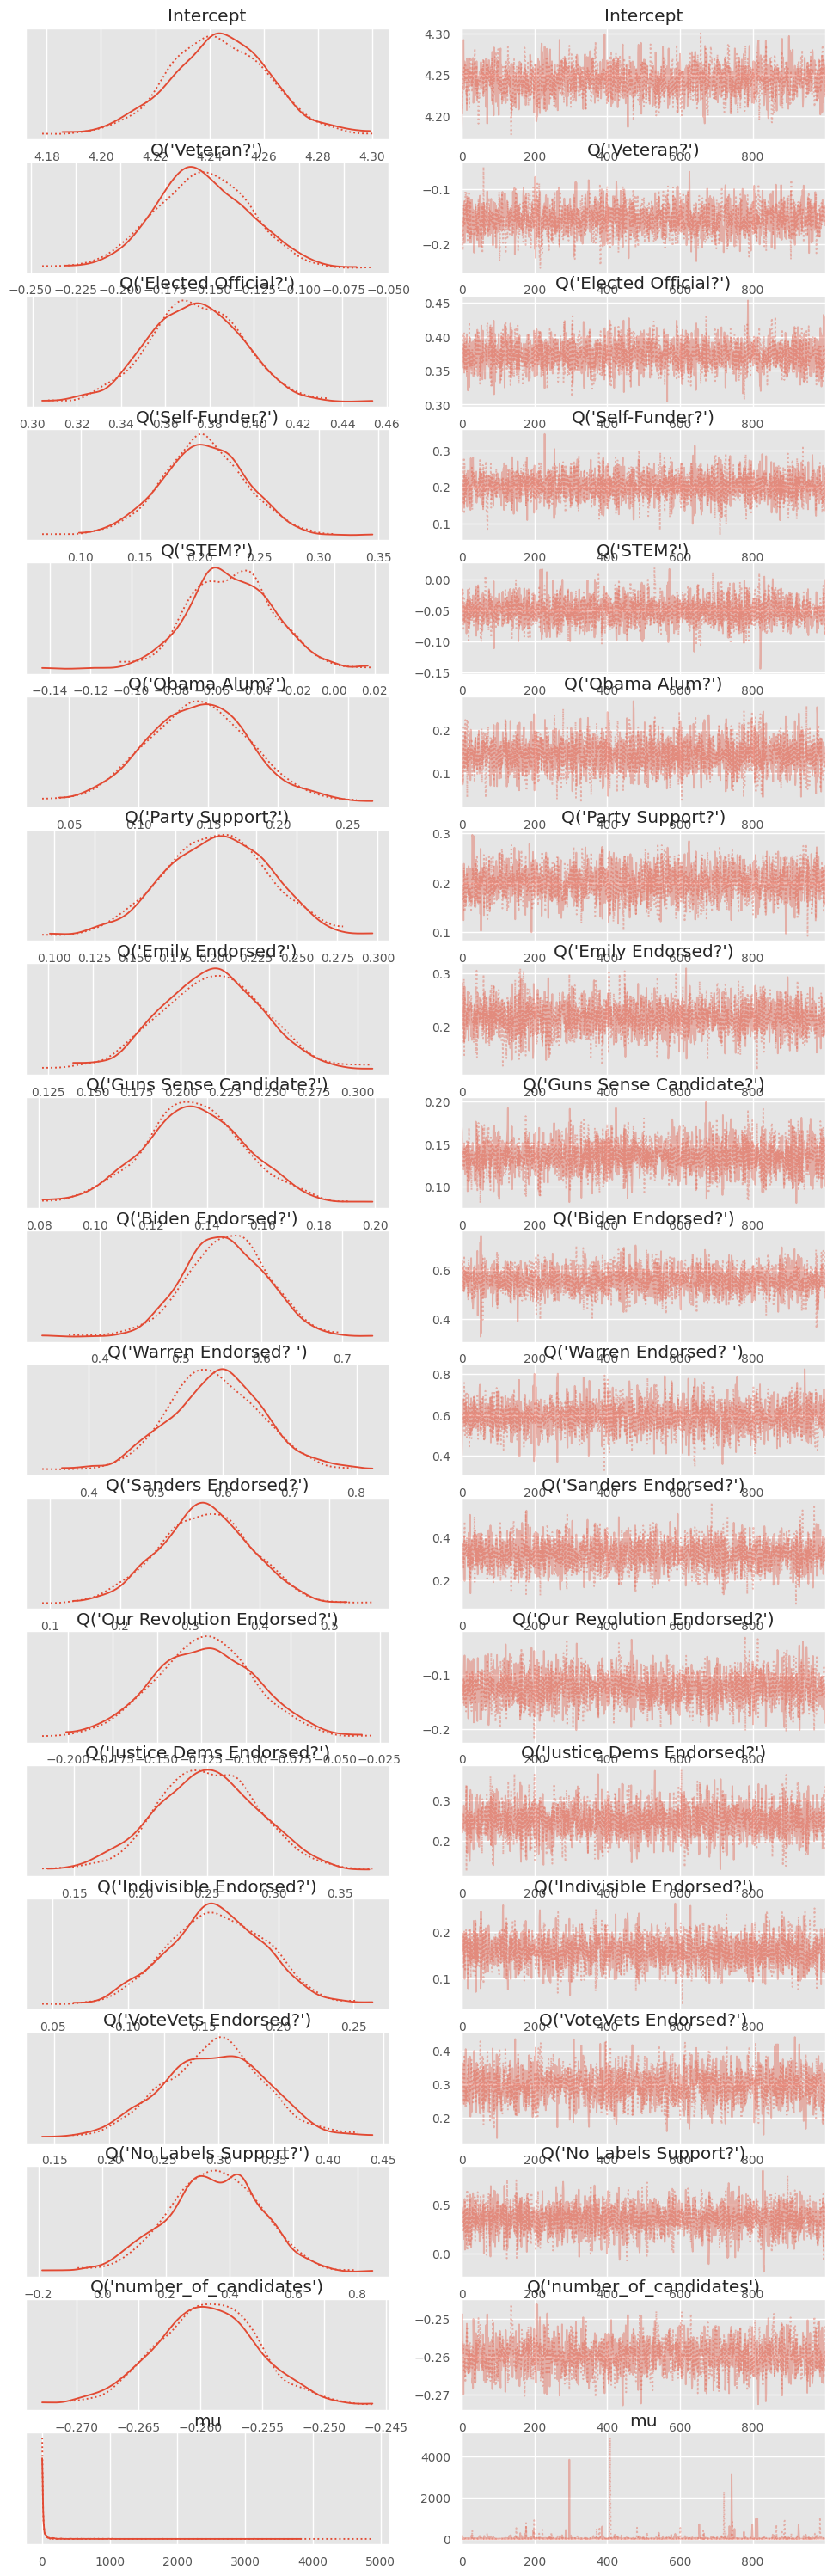

In [116]:
az.plot_trace(poisson_trace);

In [117]:
pm.summary(poisson_trace)
#az.summary(np.exp(poisson_trace.posterior), kind="stats")

Got error No model on context stack. trying to find log_likelihood in translation.
/root/venv/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning:

Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.



mean       sd  hdi_3%  hdi_97%  mcse_mean   
Intercept                       4.243    0.018   4.208    4.275      0.000  \
Q('Veteran?')                  -0.154    0.026  -0.198   -0.102      0.001   
Q('Elected Official?')          0.374    0.020   0.337    0.412      0.000   
Q('Self-Funder?')               0.203    0.035   0.138    0.270      0.001   
Q('STEM?')                     -0.051    0.020  -0.089   -0.014      0.000   
Q('Obama Alum?')                0.143    0.037   0.070    0.209      0.001   
Q('Party Support?')             0.200    0.032   0.141    0.258      0.001   
Q('Emily Endorsed?')            0.218    0.029   0.166    0.270      0.001   
Q('Guns Sense Candidate?')      0.135    0.018   0.102    0.171      0.000   
Q('Biden Endorsed?')            0.556    0.051   0.461    0.647      0.001   
Q('Warren Endorsed? ')          0.590    0.070   0.459    0.719      0.001   
Q('Sanders Endorsed?')          0.321    0.066   0.195    0.441      0.001   
Q('Our Revolution Endorsed?')  -0.123    0.028  -0.175   -0.067      0.001   
Q('Justice Dems Endorsed?')     0.250    0.039   0.178    0.325      0.001   
Q('Indivisible Endorsed?')      0.159    0.032   0.098    0.216      0.001   
Q('VoteVets Endorsed?')         0.296    0.047   0.203    0.378      0.001   
Q('No Labels Support?')         0.350    0.145   0.082    0.620      0.003   
Q('number_of_candidates')      -0.260    0.004  -0.267   -0.252      0.000   
mu                             42.126  191.592   0.003  120.916      5.403   

                               mcse_sd  ess_bulk  ess_tail  r_hat  
Intercept                        0.000    1426.0    1153.0    1.0  
Q('Veteran?')                    0.000    1796.0    1554.0    1.0  
Q('Elected Official?')           0.000    1988.0    1447.0    1.0  
Q('Self-Funder?')                0.000    3224.0    1529.0    1.0  
Q('STEM?')                       0.000    2785.0    1115.0    1.0  
Q('Obama Alum?')                 0.000    3127.0    1683.0    1.0  
Q('Party Support?')              0.001    1814.0    1671.0    1.0  
Q('Emily Endorsed?')             0.000    2446.0    1765.0    1.0  
Q('Guns Sense Candidate?')       0.000    2934.0    1530.0    1.0  
Q('Biden Endorsed?')             0.001    2191.0    1382.0    1.0  
Q('Warren Endorsed? ')           0.001    2308.0    1496.0    1.0  
Q('Sanders Endorsed?')           0.001    2541.0    1415.0    1.0  
Q('Our Revolution Endorsed?')    0.000    2589.0    1443.0    1.0  
Q('Justice Dems Endorsed?')      0.001    2626.0    1354.0    1.0  
Q('Indivisible Endorsed?')       0.000    2515.0    1454.0    1.0  
Q('VoteVets Endorsed?')          0.001    1540.0    1432.0    1.0  
Q('No Labels Support?')          0.002    2734.0    1308.0    1.0  
Q('number_of_candidates')        0.000    1634.0    1277.0    1.0  
mu                               3.822    3304.0    1187.0    1.0

Got error No model on context stack. trying to find log_likelihood in translation.
/root/venv/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning:

Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.



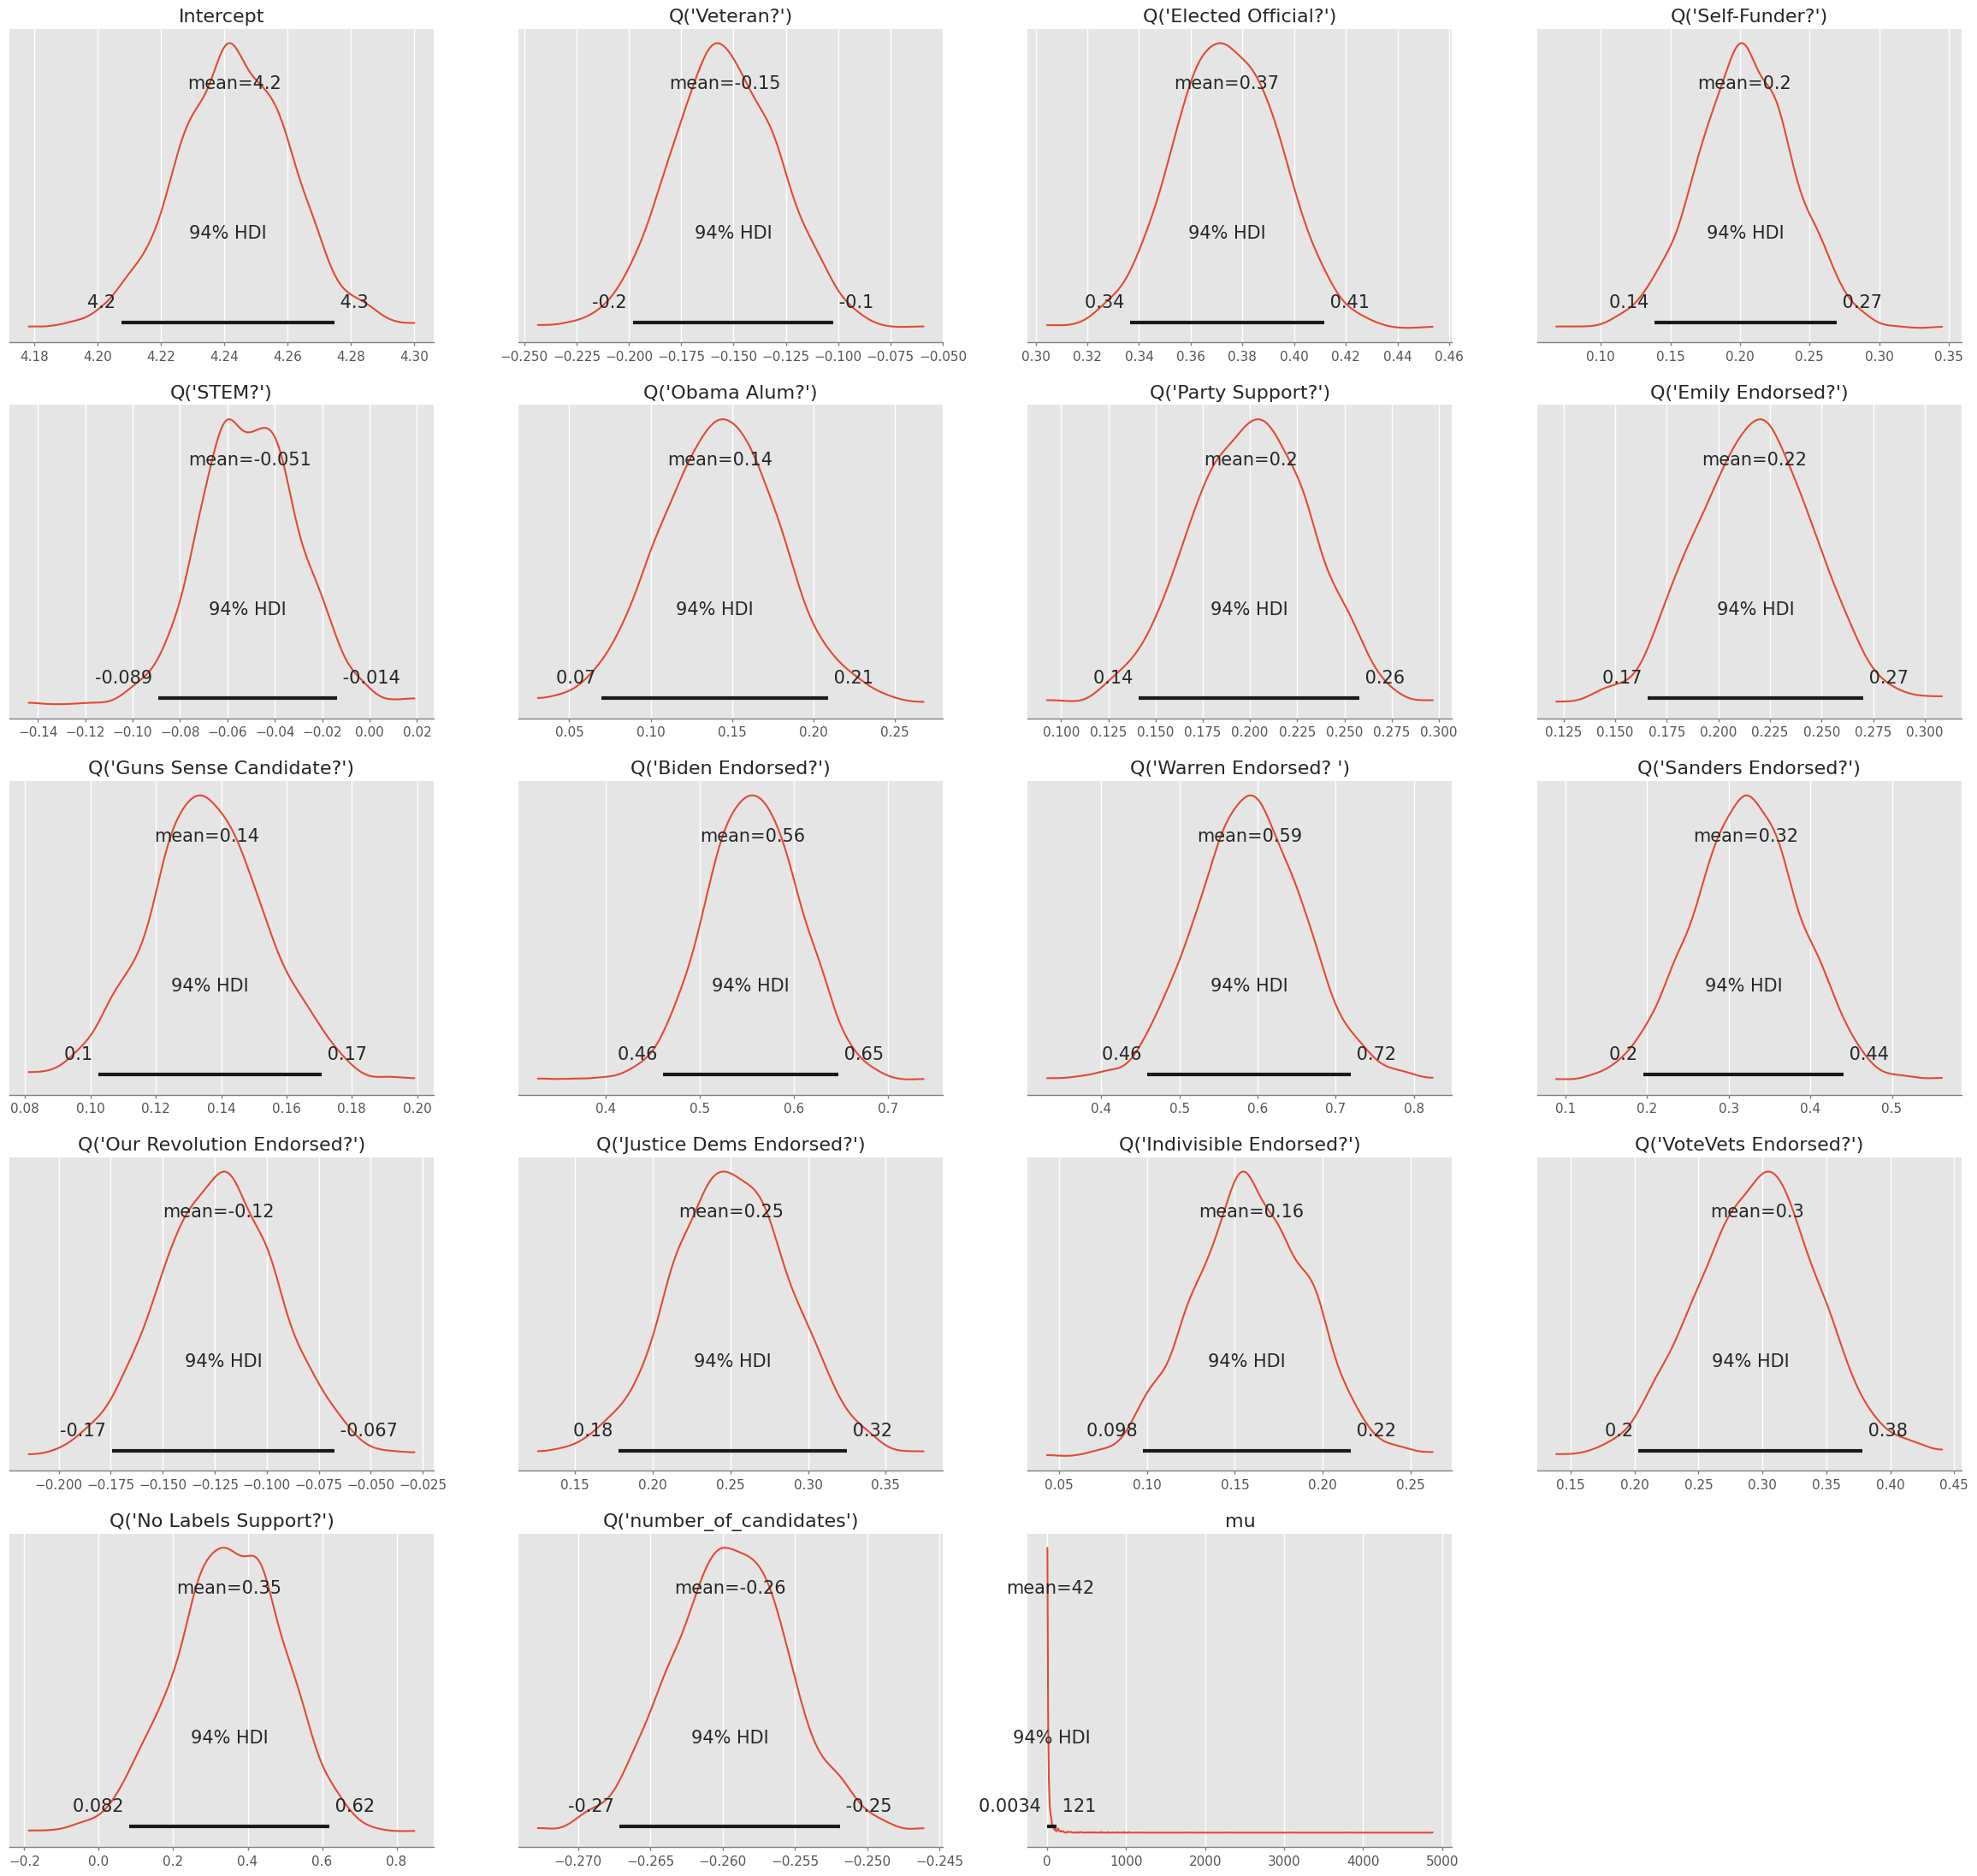

In [118]:
pm.plot_posterior(poisson_trace);

In [119]:
# Prediction reference:
# https://towardsdatascience.com/bayesian-linear-regression-in-python-using-machine-learning-to-predict-student-grades-part-2-b72059a8ac7e

In [120]:
# Make predictions for a new data point from the model trace
def query_model(trace, new_observation):
    
    # Dictionary of all sampled values for each parameter
    var_dict = {}
    for variable in trace.varnames:
        var_dict[variable] = trace[variable]
    
    # Results into a dataframe
    var_weights = pd.DataFrame(var_dict)
    
    # Align weights and new observation
    variables = []
    for var in new_observation.index:
        variables.append("Q('" + var + "')")
    variables.append("Intercept")
    variables = [var for var in trace.varnames if var in variables]
    #print(variables)
    #print(var_weights)
    var_weights = var_weights[variables]
    
    # Means of variables
    var_means = var_weights.mean(axis=0)
    
    # Mean for observation
    cols = []
    for var in variables:
        cols.append(var.replace("Q('", "").replace("')", ""))
    #print(len(cols))
    mean_loc = np.dot(var_means, new_observation[cols])
    
    return mean_loc

In [121]:
query_model(poisson_trace, test.iloc[0])

2.281402283292897

In [122]:
dem_poisson_train_pred = []
for i in range(len(train)):
    dem_poisson_train_pred.append(query_model(poisson_trace, train.iloc[i]))

dem_poisson_test_pred = []
for i in range(len(test)):
    dem_poisson_test_pred.append(query_model(poisson_trace, test.iloc[i]))

dem_train_rmse = np.mean((dem_poisson_train_pred - train['Primary %']) ** 2) ** 0.5
dem_test_rmse = np.mean((dem_poisson_test_pred - test['Primary %']) ** 2) ** 0.5

print("Democrat Train RMSE (Poisson):")
print(dem_train_rmse)
print("Democrat Test RMSE (Poisson):")
print(dem_test_rmse)

Democrat Train RMSE (Poisson):
37.26267595342532
Democrat Test RMSE (Poisson):
36.13189273619873


In [123]:
#Gaussian

In [124]:
with pm.Model() as gaussian_model:
    # Specify glm and pass in data. This is similar to the code from
    # Lab 3 that created `theta = pm.Beta(...)`, etc., but using PyMC3's 
    # GLM module sets everything up automaticaly. 
    # The resulting linear model, its likelihood and
    # and all its parameters are automatically added to our model.
    glm.GLM.from_formula("Q('Primary %') ~ Q('Elected Official?') + Q('Party Support?') + Q('Biden Endorsed?') + Q('Indivisible Endorsed?') + Q('number_of_candidates')", train)
    # draw posterior samples using NUTS sampling
    gaussian_trace = pm.sample(1000, cores=2, target_accept=0.95)#, return_inferencedata=True)

The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/
/root/venv/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning:

In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, Q('number_of_candidates'), Q('Indivisible Endorsed?'), Q('Biden Endorsed?'), Q('Party Support?'), Q('Elected Official?'), Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 22 seconds.


In [125]:
gaussian_trace

<MultiTrace: 2 chains, 1000 iterations, 8 variables>

Got error No model on context stack. trying to find log_likelihood in translation.
/root/venv/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning:

Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.

Got error No model on context stack. trying to find log_likelihood in translation.


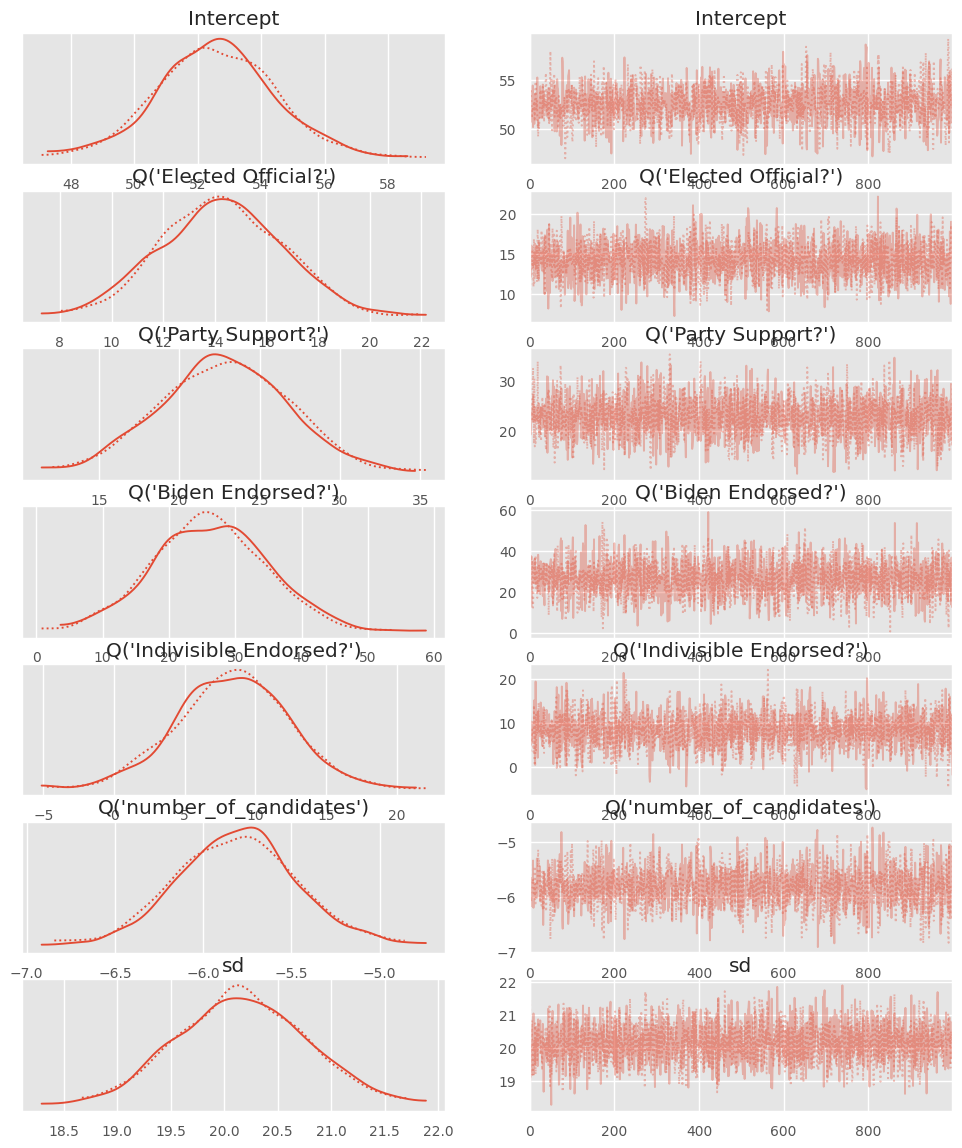

In [126]:
az.plot_trace(gaussian_trace);

In [127]:
pm.summary(gaussian_trace)

Got error No model on context stack. trying to find log_likelihood in translation.
/root/venv/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning:

Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.



mean     sd  hdi_3%  hdi_97%  mcse_mean   
Intercept                   52.570  1.855  49.108   56.252      0.050  \
Q('Elected Official?')      14.261  2.312  10.197   18.729      0.053   
Q('Party Support?')         22.812  4.011  15.527   30.575      0.089   
Q('Biden Endorsed?')        26.220  8.521   9.984   42.199      0.179   
Q('Indivisible Endorsed?')   8.352  3.963   0.746   15.676      0.089   
Q('number_of_candidates')   -5.812  0.347  -6.472   -5.140      0.009   
sd                          20.164  0.586  19.067   21.232      0.012   

                            mcse_sd  ess_bulk  ess_tail  r_hat  
Intercept                     0.035    1380.0    1062.0   1.01  
Q('Elected Official?')        0.038    1899.0    1360.0   1.00  
Q('Party Support?')           0.063    2027.0    1448.0   1.00  
Q('Biden Endorsed?')          0.128    2274.0    1675.0   1.00  
Q('Indivisible Endorsed?')    0.065    2015.0    1293.0   1.00  
Q('number_of_candidates')     0.006    1432.0    1260.0   1.00  
sd                            0.008    2472.0    1524.0   1.00

Got error No model on context stack. trying to find log_likelihood in translation.
/root/venv/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning:

Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.



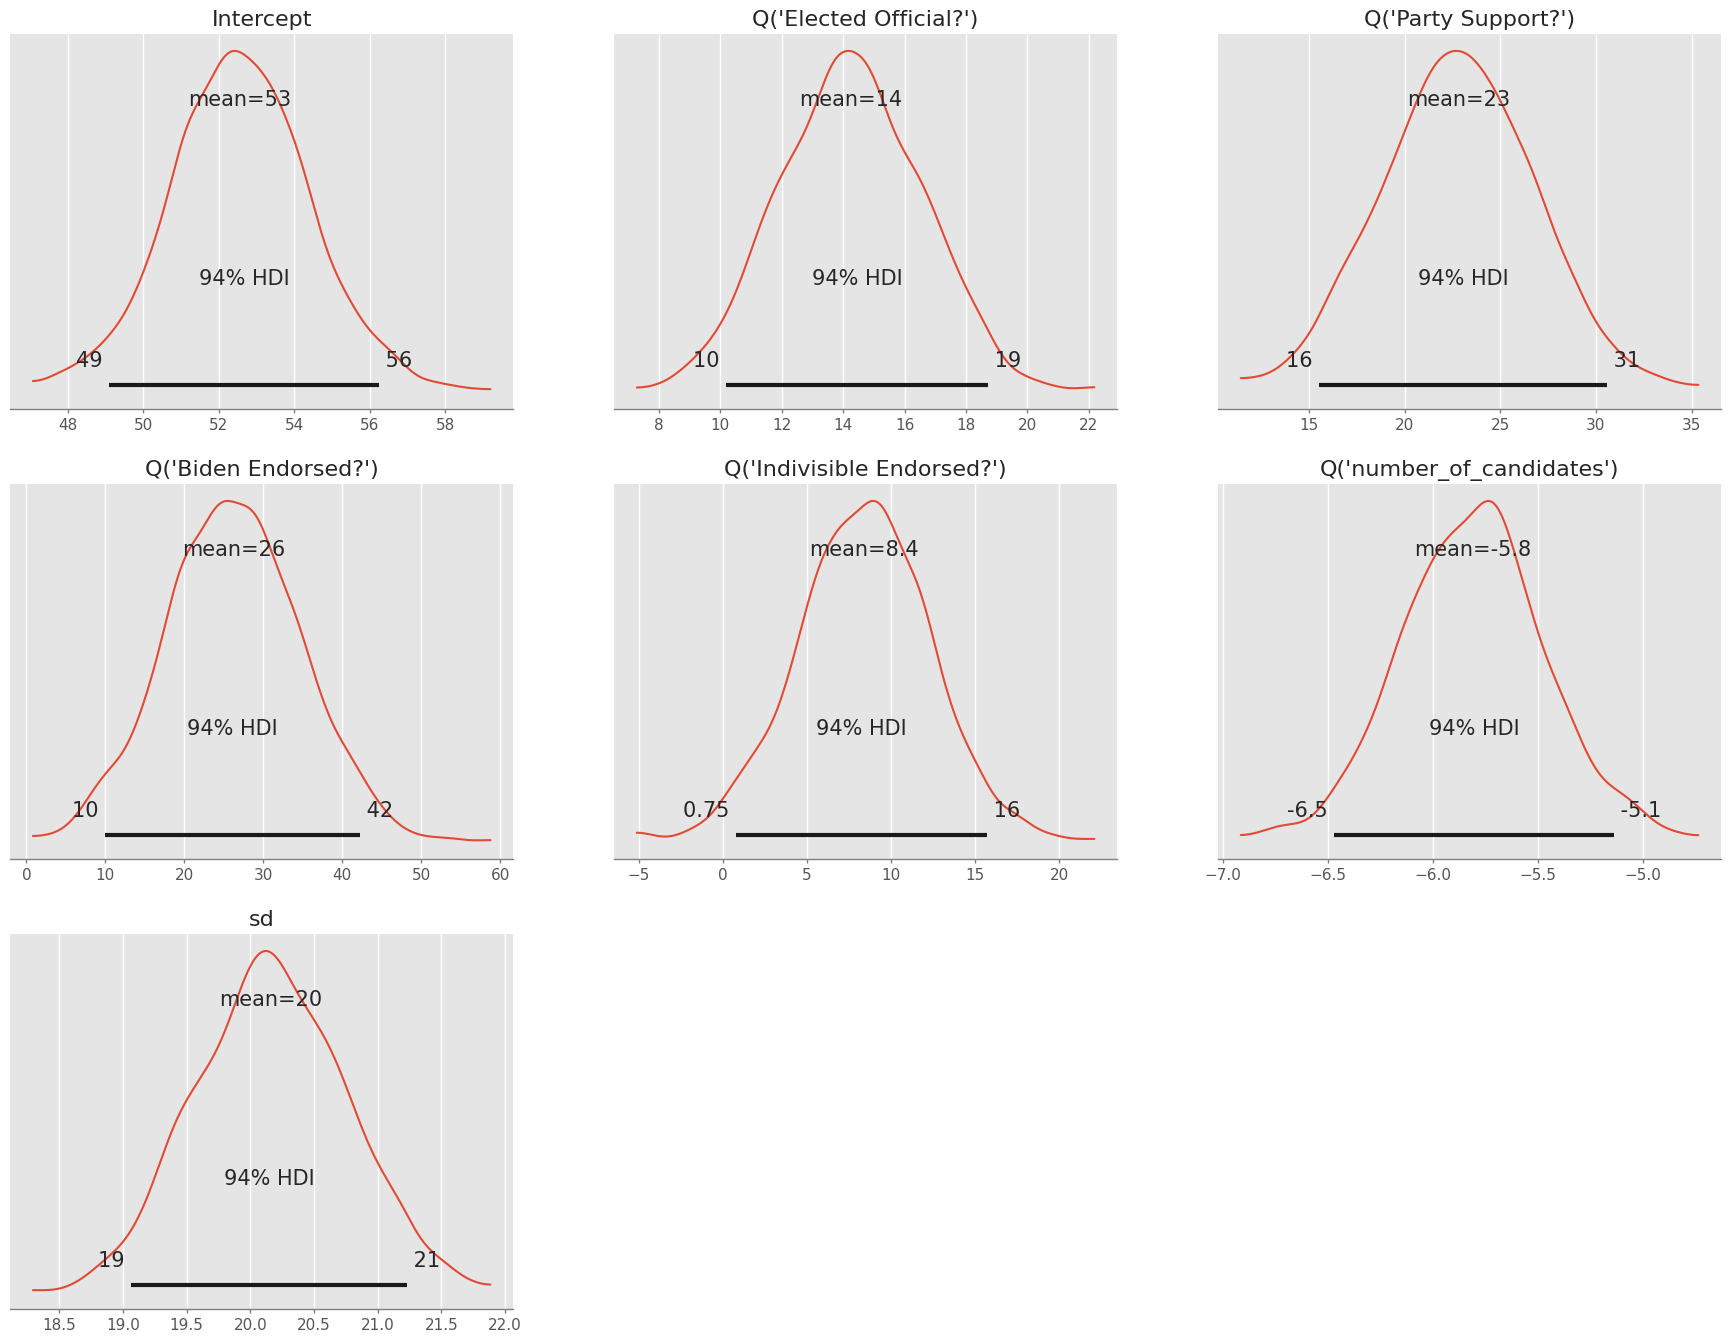

In [128]:
pm.plot_posterior(gaussian_trace);

In [129]:
query_model(gaussian_trace, test.iloc[0])

14.524990896503866

In [130]:
dem_gaussian_train_pred = []
for i in range(len(train)):
    dem_gaussian_train_pred.append(query_model(gaussian_trace, train.iloc[i]))

dem_gaussian_test_pred = []
for i in range(len(test)):
    dem_gaussian_test_pred.append(query_model(gaussian_trace, test.iloc[i]))

dem_train_rmse = np.mean((dem_gaussian_train_pred - train['Primary %']) ** 2) ** 0.5
dem_test_rmse = np.mean((dem_gaussian_test_pred - test['Primary %']) ** 2) ** 0.5

print("Democrat Train RMSE (Gaussian):")
print(dem_train_rmse)
print("Democrat Test RMSE (Gaussian):")
print(dem_test_rmse)

Democrat Train RMSE (Gaussian):
20.038331201132358
Democrat Test RMSE (Gaussian):
18.811635729871487


In [131]:
#Negative Binomial

In [132]:
with pm.Model() as negbin_model:
    glm.GLM.from_formula("Q('Primary %') ~ Q('Elected Official?') + Q('Guns Sense Candidate?') + Q('number_of_candidates')", train, family=glm.families.NegativeBinomial())
    # draw posterior samples using NUTS sampling
    negbin_trace = pm.sample(1000, cores=2, target_accept=0.95)

The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/
/root/venv/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning:

In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, mu, Q('number_of_candidates'), Q('Guns Sense Candidate?'), Q('Elected Official?'), Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 34 seconds.


In [133]:
negbin_trace

<MultiTrace: 2 chains, 1000 iterations, 8 variables>

Got error No model on context stack. trying to find log_likelihood in translation.
/root/venv/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning:

Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.

Got error No model on context stack. trying to find log_likelihood in translation.


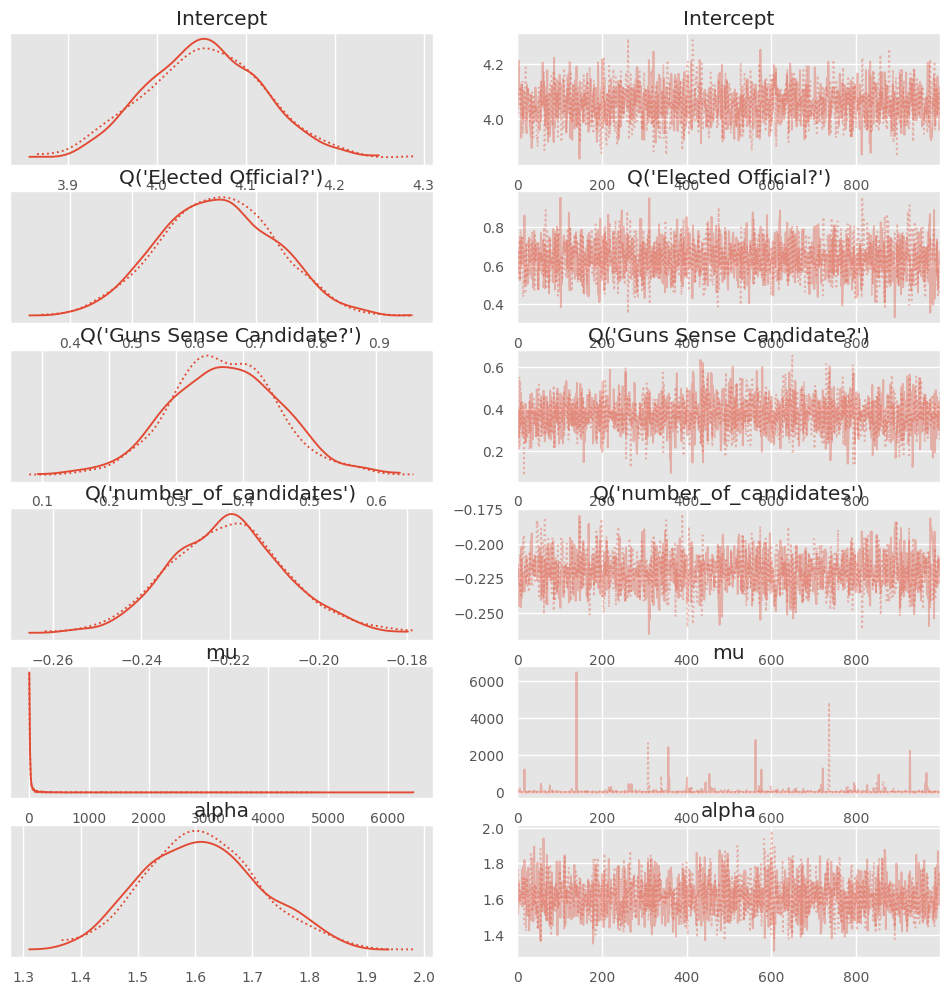

In [134]:
az.plot_trace(negbin_trace);

In [135]:
pm.summary(negbin_trace)

Got error No model on context stack. trying to find log_likelihood in translation.
/root/venv/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning:

Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.



mean       sd  hdi_3%  hdi_97%  mcse_mean   
Intercept                    4.054    0.066   3.928    4.174      0.002  \
Q('Elected Official?')       0.638    0.095   0.453    0.804      0.002   
Q('Guns Sense Candidate?')   0.373    0.082   0.219    0.528      0.002   
Q('number_of_candidates')   -0.221    0.013  -0.245   -0.195      0.000   
mu                          41.285  230.230   0.005   97.478      5.753   
alpha                        1.613    0.102   1.424    1.805      0.002   

                            mcse_sd  ess_bulk  ess_tail  r_hat  
Intercept                     0.001    1325.0    1231.0   1.00  
Q('Elected Official?')        0.002    1905.0    1436.0   1.00  
Q('Guns Sense Candidate?')    0.002    1684.0    1140.0   1.00  
Q('number_of_candidates')     0.000    1271.0    1000.0   1.00  
mu                            4.069    2100.0    1068.0   1.01  
alpha                         0.002    1793.0    1507.0   1.00

Got error No model on context stack. trying to find log_likelihood in translation.
/root/venv/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning:

Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.



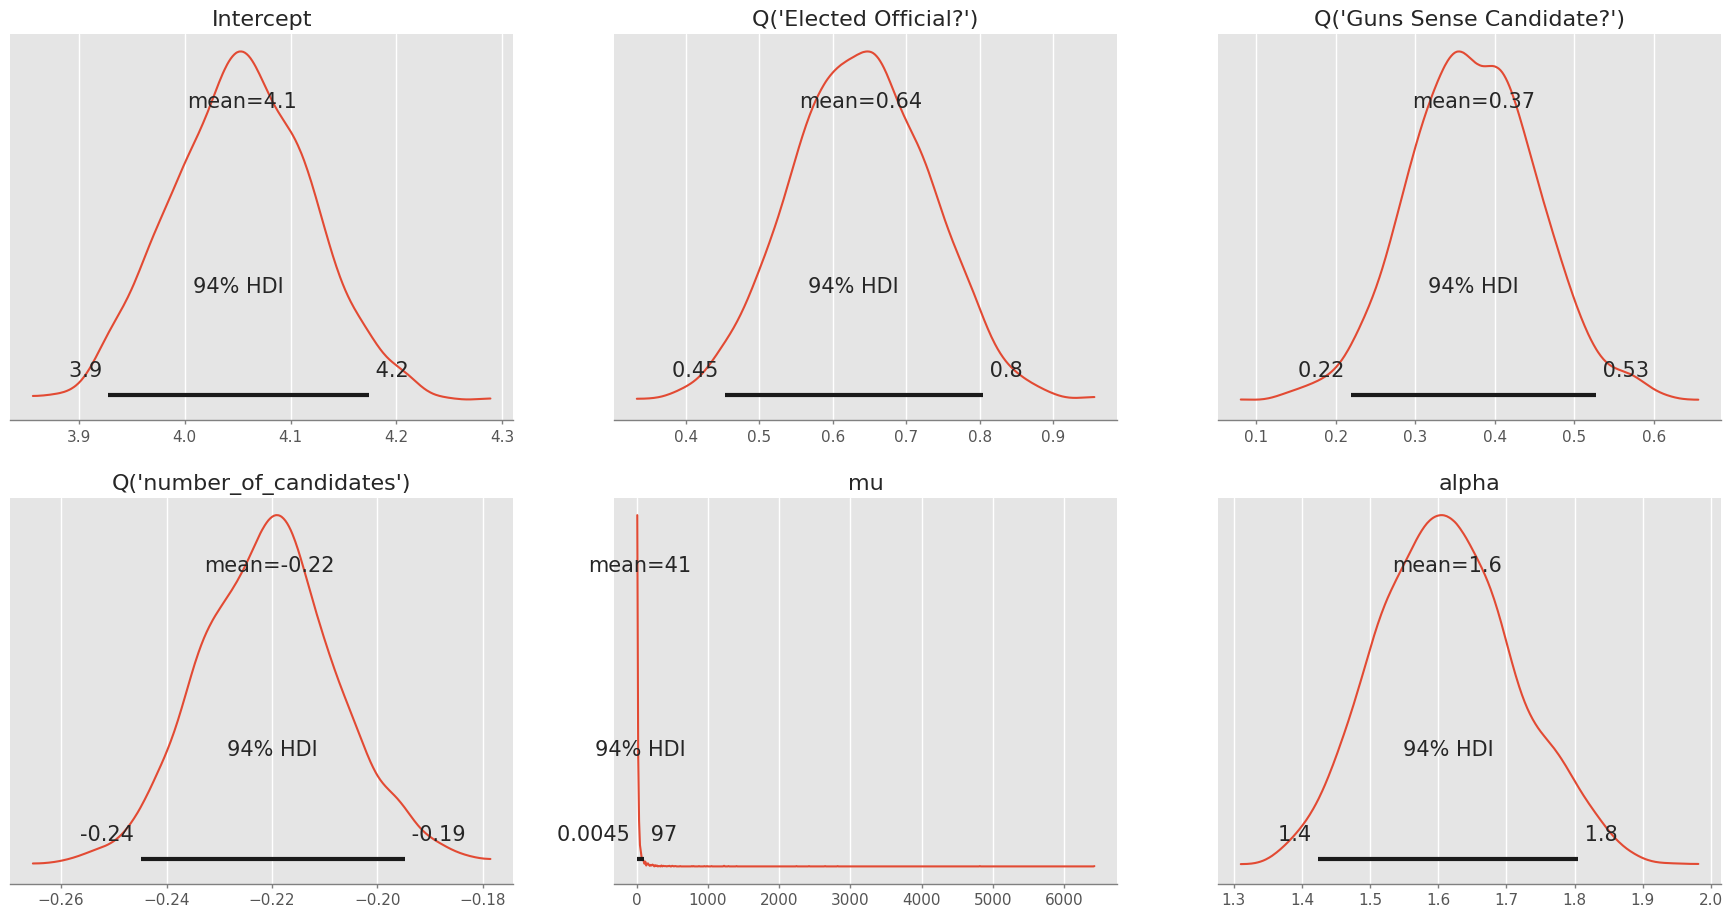

In [136]:
pm.plot_posterior(negbin_trace);

In [137]:
query_model(negbin_trace, test.iloc[0])

2.7076006975648763

In [138]:
dem_negbin_train_pred = []
for i in range(len(train)):
    dem_negbin_train_pred.append(query_model(negbin_trace, train.iloc[i]))

dem_negbin_test_pred = []
for i in range(len(test)):
    dem_negbin_test_pred.append(query_model(negbin_trace, test.iloc[i]))

dem_train_rmse = np.mean((dem_negbin_train_pred - train['Primary %']) ** 2) ** 0.5
dem_test_rmse = np.mean((dem_negbin_test_pred - test['Primary %']) ** 2) ** 0.5

print("Democrat Train RMSE (Negative Binomial):")
print(dem_train_rmse)
print("Democrat Test RMSE (Negative Binomial):")
print(dem_test_rmse)

Democrat Train RMSE (Negative Binomial):
37.29281479895558
Democrat Test RMSE (Negative Binomial):
36.156883949270586


## Bayesian GLM (Rep)

In [139]:
train, test = train_test_split(rep, test_size = .3, random_state = 101)

In [140]:
train['Intercept'] = np.ones(len(train))
train.head()

Candidate State                           District     Office Type   
770  Harriet Hageman    WY                Governor of Wyoming        Governor  \
16   Nicolas Pierson    AZ      U.S. House Arizona District 3  Representative   
479       Dan DeBono    NY     U.S. House New York District 3  Representative   
80      John Briscoe    CA  U.S. House California District 47  Representative   
98       Jeff Cullen    CA  U.S. House California District 52  Representative   

    Race Primary Election Date  Primary %  Won Primary  Rep Party Support?   
770                    8/21/18      21.50          0.0                   0  \
16                     8/28/18      51.40          NaN                   0   
479                    6/26/18     100.00          NaN                   1   
80                      6/5/18      54.48          NaN                   0   
98                      6/5/18       5.88          0.0                   0   

     Trump Endorsed?  Bannon Endorsed?  ...  Susan B. Anthony Endorsed?   
770                0                 0  ...                           0  \
16                 0                 0  ...                           0   
479                0                 0  ...                           0   
80                 0                 0  ...                           0   
98                 0                 0  ...                           0   

     Club for Growth Endorsed?  Koch Support?  House Freedom Support?   
770                          0              0                       0  \
16                           0              0                       0   
479                          0              0                       0   
80                           0              0                       0   
98                           0              0                       0   

     Tea Party Endorsed?  Main Street Endorsed?  Chamber Endorsed?   
770                    0                      0                  0  \
16                     0                      0                  0   
479                    0                      0                  0   
80                     0                      0                  0   
98                     0                      0                  0   

     No Labels Support?  number_of_candidates  Intercept  
770                   0                     1        1.0  
16                    0                     2        1.0  
479                   0                     5        1.0  
80                    0                     8        1.0  
98                    0                     4        1.0  

[5 rows x 23 columns]

In [141]:
test['Intercept'] = np.ones(len(test))
test.head()

Candidate State                           District   
533      Andy Coleman    OK     U.S. House Oklahoma District 1  \
237  Mark Wayne Lorch    IL     U.S. House Illinois District 4   
42   Cristina OsmeÌ±a    CA  U.S. House California District 14   
682      SK Alexander    TX       U.S. House Texas District 35   
547    Preston Miller    OR       U.S. House Oregon District 1   

        Office Type Race Primary Election Date  Primary %  Won Primary   
533  Representative                    6/26/18      21.85          0.0  \
237  Representative                    3/20/18     100.00          NaN   
42   Representative                     6/5/18     100.00          NaN   
682  Representative                     3/6/18      46.70          0.0   
547  Representative                    5/15/18       7.71          0.0   

     Rep Party Support?  Trump Endorsed?  Bannon Endorsed?  ...   
533                   0                0                 0  ...  \
237                   0                0                 0  ...   
42                    0                0                 0  ...   
682                   0                0                 0  ...   
547                   0                0                 0  ...   

     Susan B. Anthony Endorsed?  Club for Growth Endorsed?  Koch Support?   
533                           0                          0              0  \
237                           0                          0              0   
42                            0                          0              0   
682                           0                          0              0   
547                           0                          0              0   

     House Freedom Support?  Tea Party Endorsed?  Main Street Endorsed?   
533                       1                    0                      0  \
237                       0                    0                      0   
42                        0                    0                      0   
682                       0                    0                      0   
547                       0                    0                      0   

     Chamber Endorsed?  No Labels Support?  number_of_candidates  Intercept  
533                  0                   0                     4        1.0  
237                  0                   0                     6        1.0  
42                   0                   0                     4        1.0  
682                  0                   0                     6        1.0  
547                  0                   0                     4        1.0  

[5 rows x 23 columns]

In [142]:
#Poisson

In [143]:
with pm.Model() as poisson_model_rep:
    glm.GLM.from_formula("Q('Primary %') ~ Q('Rep Party Support?') + Q('Trump Endorsed?') + Q('Bannon Endorsed?') + Q('Right to Life Endorsed?') + Q('Susan B. Anthony Endorsed?') + Q('Club for Growth Endorsed?') + Q('Koch Support?') + Q('Tea Party Endorsed?') + Q('Main Street Endorsed?') + Q('Chamber Endorsed?')", train, family=glm.families.Poisson())
    # draw posterior samples using NUTS sampling
    poisson_trace_rep = pm.sample(1000, cores=2, target_accept=0.95)#, return_inferencedata=True)

The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/
/root/venv/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning:

In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, Q('Chamber Endorsed?'), Q('Main Street Endorsed?'), Q('Tea Party Endorsed?'), Q('Koch Support?'), Q('Club for Growth Endorsed?'), Q('Susan B. Anthony Endorsed?'), Q('Right to Life Endorsed?'), Q('Bannon Endorsed?'), Q('Trump Endorsed?'), Q('Rep Party Support?'), Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 37 seconds.


In [144]:
poisson_trace_rep

<MultiTrace: 2 chains, 1000 iterations, 13 variables>

Got error No model on context stack. trying to find log_likelihood in translation.
/root/venv/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning:

Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.

Got error No model on context stack. trying to find log_likelihood in translation.


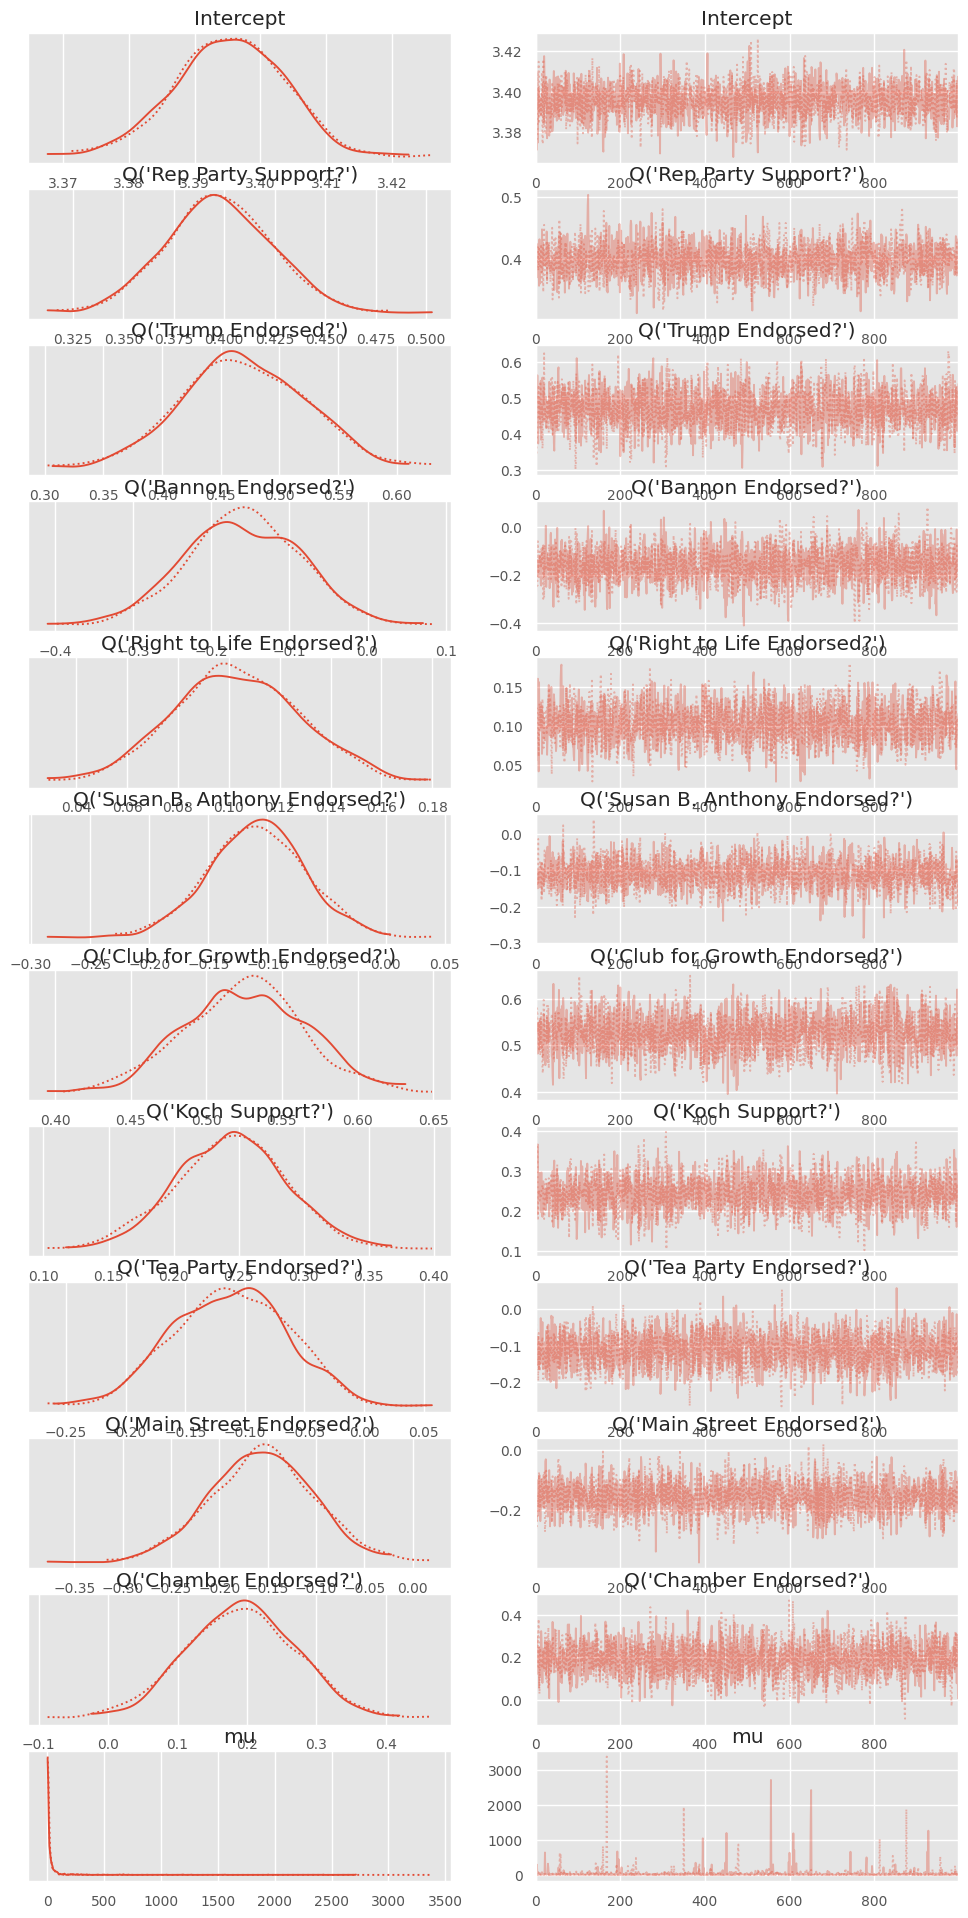

In [145]:
az.plot_trace(poisson_trace_rep);

In [146]:
pm.summary(poisson_trace_rep)

Got error No model on context stack. trying to find log_likelihood in translation.
/root/venv/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning:

Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.



mean       sd  hdi_3%  hdi_97%  mcse_mean   
Intercept                         3.395    0.008   3.379    3.410      0.000  \
Q('Rep Party Support?')           0.397    0.026   0.351    0.449      0.001   
Q('Trump Endorsed?')              0.469    0.054   0.367    0.565      0.001   
Q('Bannon Endorsed?')            -0.160    0.074  -0.299   -0.027      0.002   
Q('Right to Life Endorsed?')      0.103    0.025   0.059    0.150      0.001   
Q('Susan B. Anthony Endorsed?')  -0.109    0.041  -0.183   -0.029      0.001   
Q('Club for Growth Endorsed?')    0.525    0.041   0.453    0.607      0.001   
Q('Koch Support?')                0.244    0.043   0.159    0.321      0.001   
Q('Tea Party Endorsed?')         -0.112    0.048  -0.196   -0.025      0.001   
Q('Main Street Endorsed?')       -0.156    0.053  -0.268   -0.069      0.001   
Q('Chamber Endorsed?')            0.191    0.079   0.041    0.332      0.002   
mu                               39.020  157.843   0.018   94.913      3.969   

                                 mcse_sd  ess_bulk  ess_tail  r_hat  
Intercept                          0.000    2108.0    1472.0   1.00  
Q('Rep Party Support?')            0.000    1922.0    1598.0   1.00  
Q('Trump Endorsed?')               0.001    2080.0    1529.0   1.00  
Q('Bannon Endorsed?')              0.001    1986.0    1269.0   1.01  
Q('Right to Life Endorsed?')       0.000    1842.0    1353.0   1.00  
Q('Susan B. Anthony Endorsed?')    0.001    1799.0    1473.0   1.00  
Q('Club for Growth Endorsed?')     0.001    2040.0    1408.0   1.00  
Q('Koch Support?')                 0.001    1832.0    1436.0   1.00  
Q('Tea Party Endorsed?')           0.001    2034.0    1475.0   1.00  
Q('Main Street Endorsed?')         0.001    2144.0    1550.0   1.00  
Q('Chamber Endorsed?')             0.001    2112.0    1316.0   1.00  
mu                                 2.807    2683.0    1070.0   1.00

Got error No model on context stack. trying to find log_likelihood in translation.
/root/venv/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning:

Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.



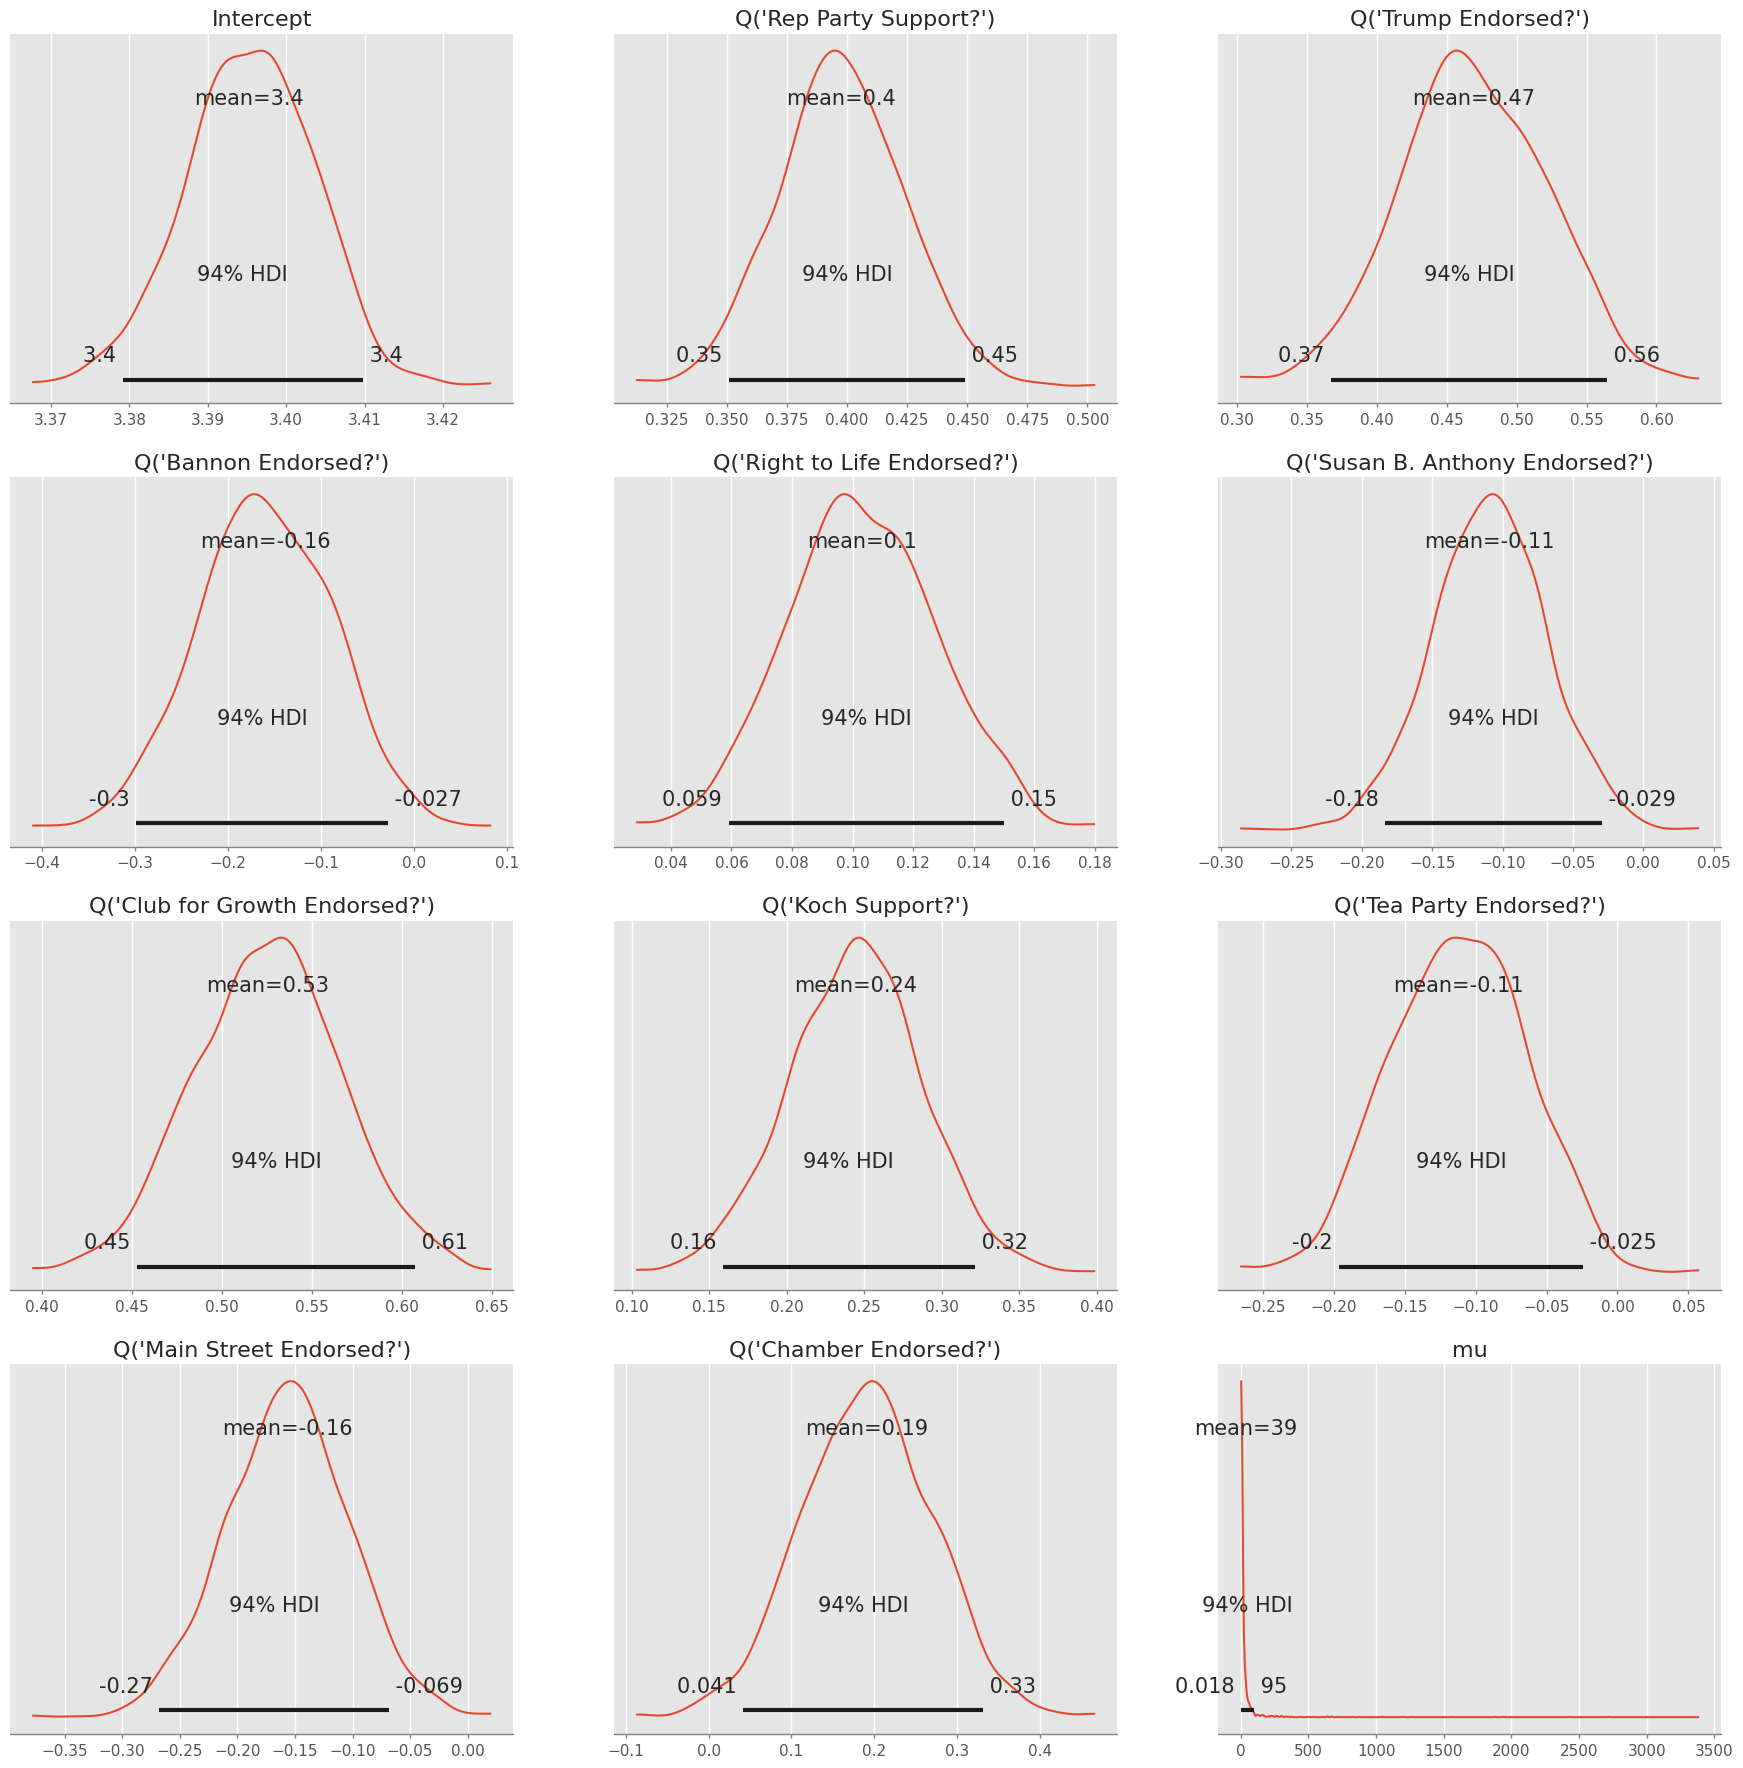

In [147]:
pm.plot_posterior(poisson_trace_rep);

In [148]:
query_model(poisson_trace_rep, test.iloc[0])

3.3953052678215143

In [149]:
rep_poisson_train_pred = []
for i in range(len(train)):
    rep_poisson_train_pred.append(query_model(poisson_trace_rep, train.iloc[i]))

rep_poisson_test_pred = []
for i in range(len(test)):
    rep_poisson_test_pred.append(query_model(poisson_trace_rep, test.iloc[i]))

rep_train_rmse = np.mean((rep_poisson_train_pred - train['Primary %']) ** 2) ** 0.5
rep_test_rmse = np.mean((rep_poisson_test_pred - test['Primary %']) ** 2) ** 0.5

print("Republican Train RMSE (Poisson):")
print(rep_train_rmse)
print("Republican Test RMSE (Poisson):")
print(rep_test_rmse)

Republican Train RMSE (Poisson):
43.942316414889405
Republican Test RMSE (Poisson):
41.19052392207306


In [150]:
#Gaussian

In [151]:
with pm.Model() as gaussian_model_rep:
    # Specify glm and pass in data. This is similar to the code from
    # Lab 3 that created `theta = pm.Beta(...)`, etc., but using PyMC3's 
    # GLM module sets everything up automaticaly. 
    # The resulting linear model, its likelihood and
    # and all its parameters are automatically added to our model.
    glm.GLM.from_formula("Q('Primary %') ~ Q('Rep Party Support?') + Q('Club for Growth Endorsed?')", train)
    # draw posterior samples using NUTS sampling
    gaussian_trace_rep = pm.sample(1000, cores=2, target_accept=0.95)#, return_inferencedata=True)

The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/
/root/venv/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning:

In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, Q('Club for Growth Endorsed?'), Q('Rep Party Support?'), Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 13 seconds.


In [152]:
gaussian_trace_rep

<MultiTrace: 2 chains, 1000 iterations, 5 variables>

Got error No model on context stack. trying to find log_likelihood in translation.
/root/venv/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning:

Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.

Got error No model on context stack. trying to find log_likelihood in translation.


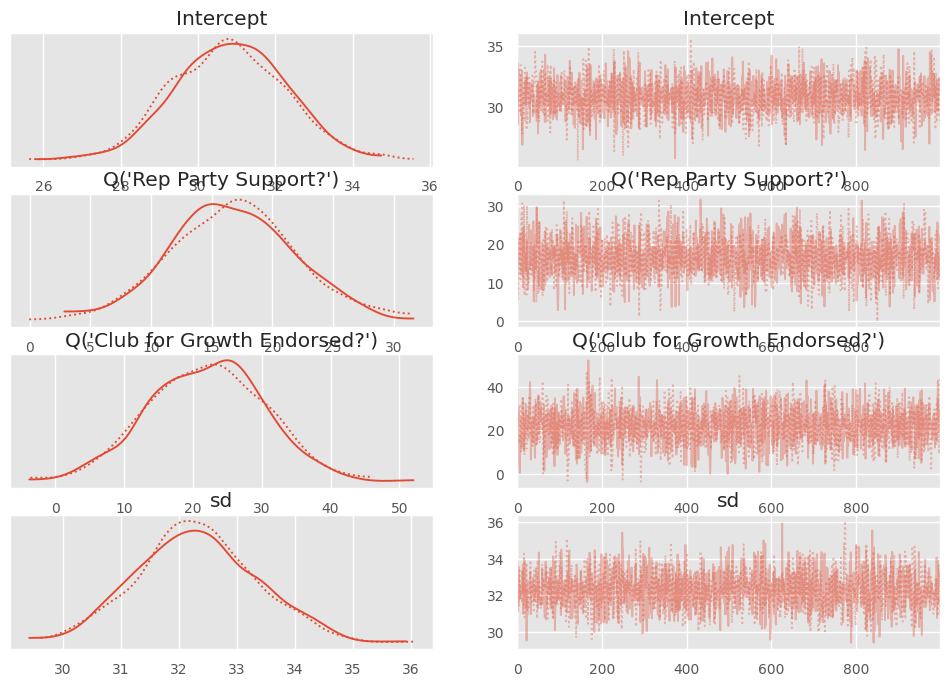

In [153]:
az.plot_trace(gaussian_trace_rep);

In [154]:
pm.summary(gaussian_trace_rep)

Got error No model on context stack. trying to find log_likelihood in translation.
/root/venv/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning:

Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.



mean     sd  hdi_3%  hdi_97%  mcse_mean   
Intercept                       30.815  1.452  28.221   33.581      0.033  \
Q('Rep Party Support?')         16.699  5.144   7.290   26.865      0.112   
Q('Club for Growth Endorsed?')  21.988  8.429   5.780   37.209      0.176   
sd                              32.311  1.024  30.454   34.265      0.023   

                                mcse_sd  ess_bulk  ess_tail  r_hat  
Intercept                         0.023    1970.0    1466.0    1.0  
Q('Rep Party Support?')           0.081    2128.0    1433.0    1.0  
Q('Club for Growth Endorsed?')    0.130    2299.0    1488.0    1.0  
sd                                0.016    2058.0    1573.0    1.0

Got error No model on context stack. trying to find log_likelihood in translation.
/root/venv/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning:

Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.



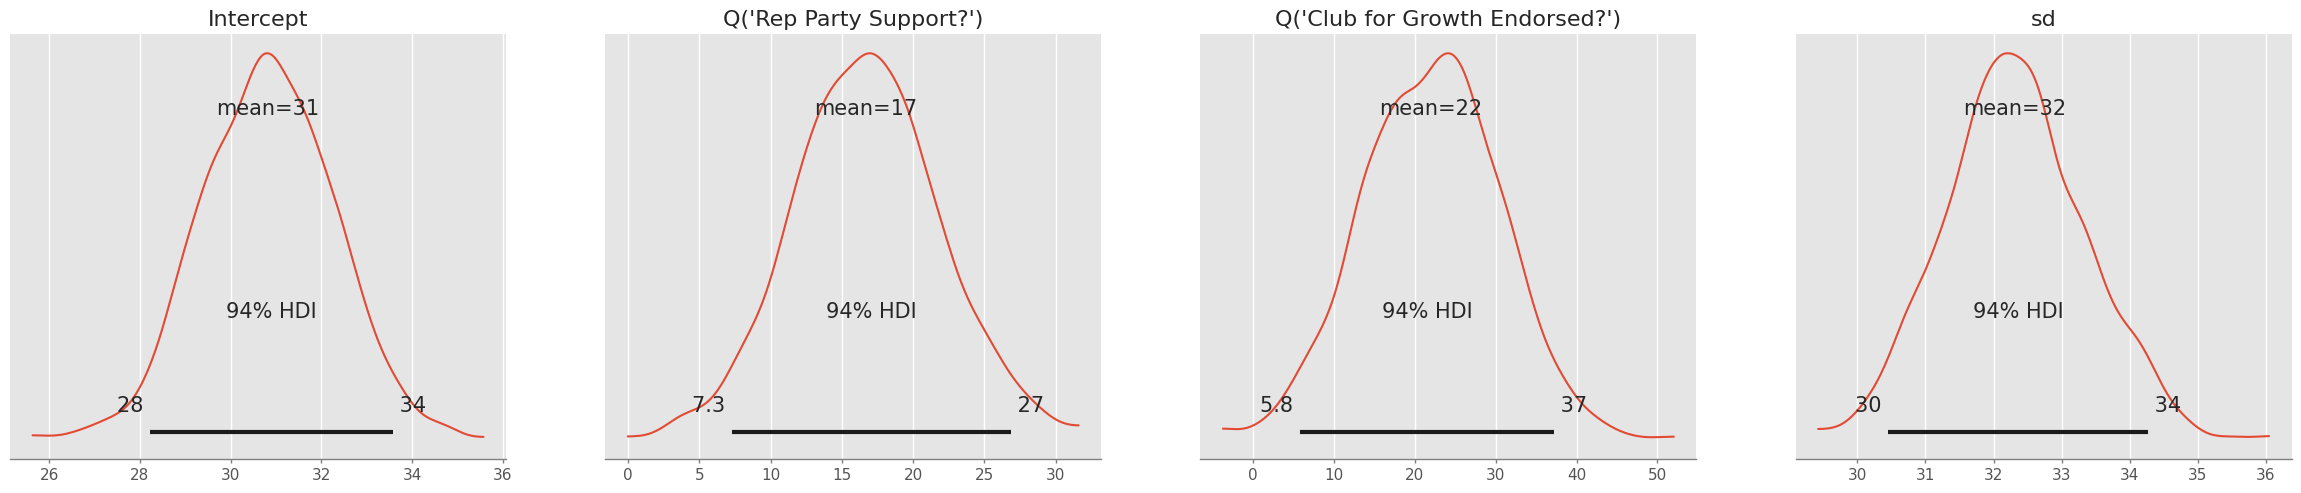

In [155]:
pm.plot_posterior(gaussian_trace_rep);

In [156]:
query_model(gaussian_trace_rep, test.iloc[0])

30.815187812685807

In [157]:
rep_gaussian_train_pred = []
for i in range(len(train)):
    rep_gaussian_train_pred.append(query_model(gaussian_trace_rep, train.iloc[i]))

rep_gaussian_test_pred = []
for i in range(len(test)):
    rep_gaussian_test_pred.append(query_model(gaussian_trace_rep, test.iloc[i]))

rep_train_rmse = np.mean((rep_gaussian_train_pred - train['Primary %']) ** 2) ** 0.5
rep_test_rmse = np.mean((rep_gaussian_test_pred - test['Primary %']) ** 2) ** 0.5

print("Republican Train RMSE (Gaussian):")
print(rep_train_rmse)
print("Republican Test RMSE (Gaussian):")
print(rep_test_rmse)

Republican Train RMSE (Gaussian):
32.22262308336504
Republican Test RMSE (Gaussian):
30.557496907056546


In [158]:
#Negative Binomial

In [159]:
with pm.Model() as negbin_model_rep:
    glm.GLM.from_formula("Q('Primary %') ~ Q('Rep Party Support?')", train, family=glm.families.NegativeBinomial())
    # draw posterior samples using NUTS sampling
    negbin_trace_rep = pm.sample(1000, cores=2, target_accept=0.95)

The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/
/root/venv/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning:

In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, mu, Q('Rep Party Support?'), Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 18 seconds.


In [160]:
negbin_trace_rep

<MultiTrace: 2 chains, 1000 iterations, 6 variables>

Got error No model on context stack. trying to find log_likelihood in translation.
/root/venv/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning:

Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.

Got error No model on context stack. trying to find log_likelihood in translation.


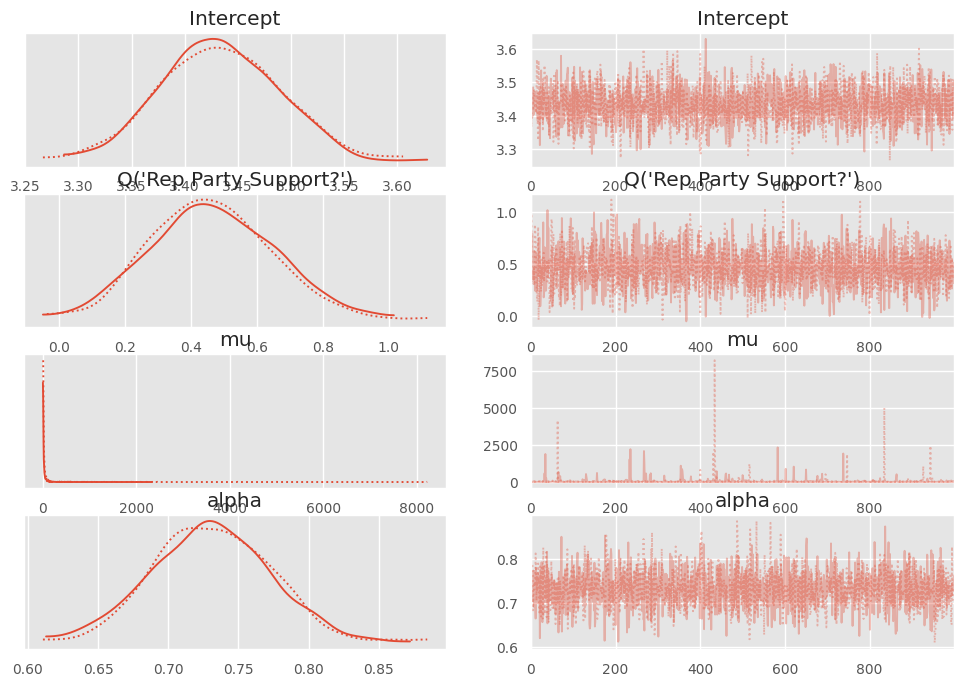

In [161]:
az.plot_trace(negbin_trace_rep);

In [162]:
pm.summary(negbin_trace_rep)

Got error No model on context stack. trying to find log_likelihood in translation.
/root/venv/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning:

Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.



mean       sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd   
Intercept                 3.433    0.055   3.336    3.537      0.001    0.001  \
Q('Rep Party Support?')   0.463    0.190   0.133    0.841      0.005    0.003   
mu                       51.793  288.520   0.018  109.061      7.996    5.655   
alpha                     0.731    0.042   0.655    0.810      0.001    0.001   

                         ess_bulk  ess_tail  r_hat  
Intercept                  2056.0    1530.0    1.0  
Q('Rep Party Support?')    1786.0    1263.0    1.0  
mu                         2041.0     992.0    1.0  
alpha                      1846.0    1228.0    1.0

Got error No model on context stack. trying to find log_likelihood in translation.
/root/venv/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning:

Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.



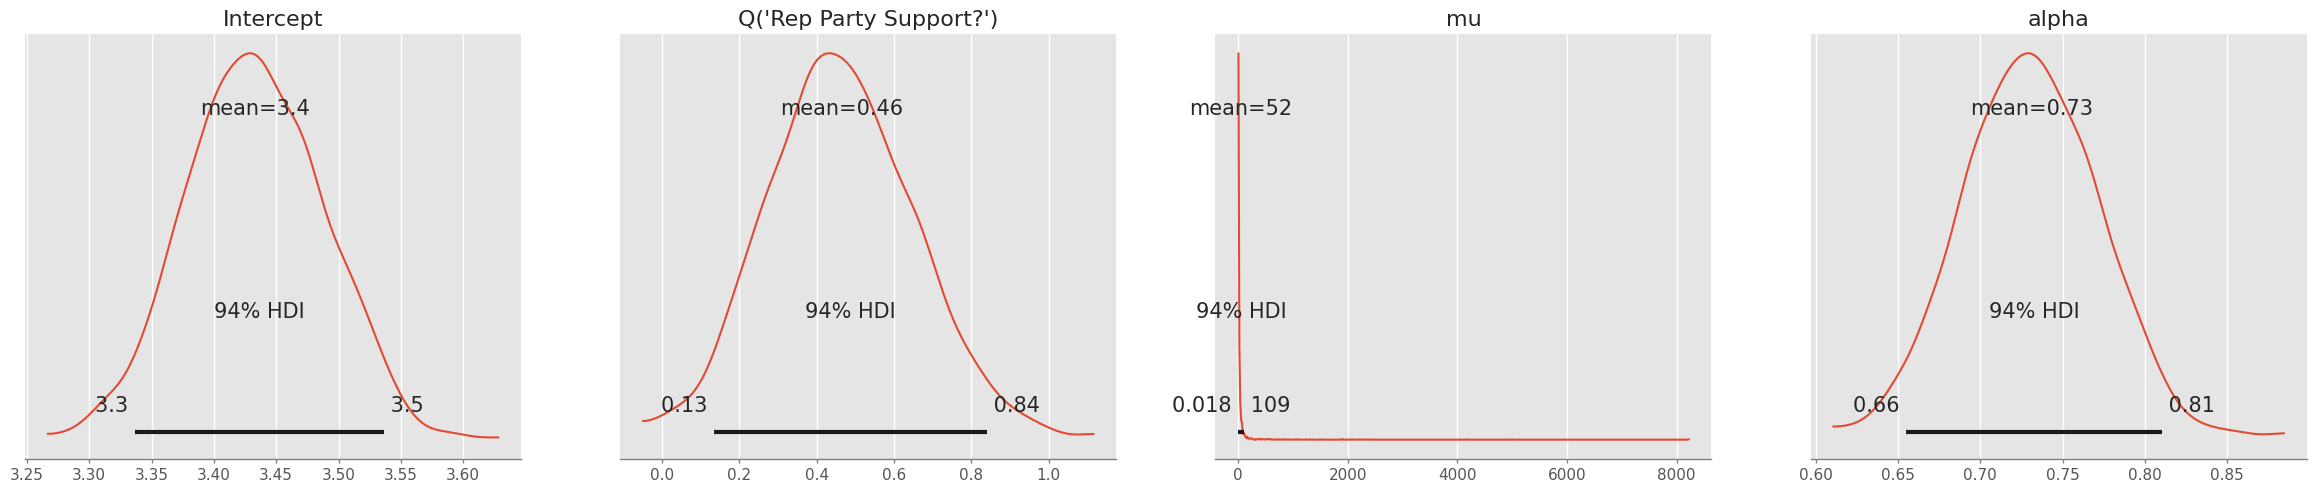

In [163]:
pm.plot_posterior(negbin_trace_rep);

In [164]:
query_model(negbin_trace_rep, test.iloc[0])

3.432999134725925

In [165]:
rep_negbin_train_pred = []
for i in range(len(train)):
    rep_negbin_train_pred.append(query_model(negbin_trace_rep, train.iloc[i]))

rep_negbin_test_pred = []
for i in range(len(test)):
    rep_negbin_test_pred.append(query_model(negbin_trace_rep, test.iloc[i]))

rep_train_rmse = np.mean((rep_negbin_train_pred - train['Primary %']) ** 2) ** 0.5
rep_test_rmse = np.mean((rep_negbin_test_pred - test['Primary %']) ** 2) ** 0.5

print("Republican Train RMSE (Negative Binomial):")
print(rep_train_rmse)
print("Republican Test RMSE (Negative Binomial):")
print(rep_test_rmse)

Republican Train RMSE (Negative Binomial):
43.95011993086409
Republican Test RMSE (Negative Binomial):
41.19699103253101


## Nonparametric Models

In [166]:
dem_train, dem_test = train_test_split(dem, test_size=0.3, train_size=0.7, random_state=101)
rep_train, rep_test = train_test_split(rep, test_size=0.3, train_size=0.7, random_state=101)

In [167]:
dem_X_cols = np.append(dem_varlist, 'number_of_candidates')
rep_X_cols = np.append(rep_varlist, 'number_of_candidates')
dem_y_col = 'Primary %'
rep_y_col = 'Primary %'

In [168]:
dem_tree_model = DecisionTreeRegressor()

dem_tree_model.fit(dem_train[dem_X_cols], dem_train[dem_y_col])

dem_train["tree_pred"] = dem_tree_model.predict(dem_train[dem_X_cols])
dem_test["tree_pred"] = dem_tree_model.predict(dem_test[dem_X_cols])

rep_tree_model = DecisionTreeRegressor()

rep_tree_model.fit(rep_train[rep_X_cols], rep_train[rep_y_col])

rep_train["tree_pred"] = rep_tree_model.predict(rep_train[rep_X_cols])
rep_test["tree_pred"] = rep_tree_model.predict(rep_test[rep_X_cols])

In [169]:
dem_train_rmse = np.mean((dem_train["tree_pred"] - dem_train[dem_y_col]) ** 2) ** 0.5
dem_test_rmse = np.mean((dem_test["tree_pred"] - dem_test[dem_y_col]) ** 2) ** 0.5

print("Democratic")
print("Training set error for decision tree:", dem_train_rmse)
print("Test set error for decision tree:    ", dem_test_rmse)

rep_train_rmse = np.mean((rep_train["tree_pred"] - rep_train[rep_y_col]) ** 2) ** 0.5
rep_test_rmse = np.mean((rep_test["tree_pred"] - rep_test[rep_y_col]) ** 2) ** 0.5

print("Republican")
print("Training set error for decision tree:", rep_train_rmse)
print("Test set error for decision tree:    ", rep_test_rmse)

Democratic
Training set error for decision tree: 11.264329042467097
Test set error for decision tree:     15.79986215197897
Republican
Training set error for decision tree: 30.018035977349516
Test set error for decision tree:     31.580310840483065


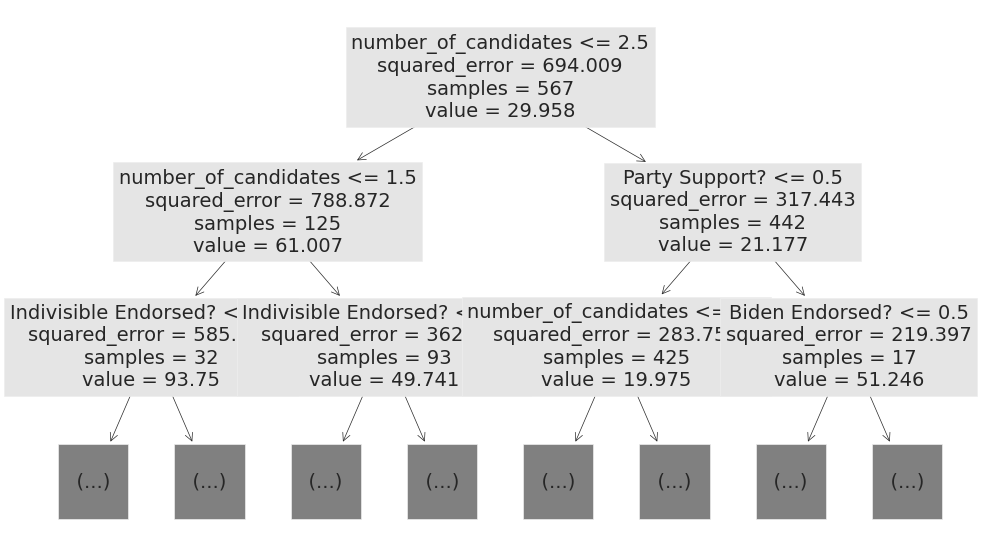

In [170]:
plt.figure(figsize=(12, 7))
plot_tree(dem_tree_model, max_depth=2, fontsize=14, feature_names=dem_X_cols);

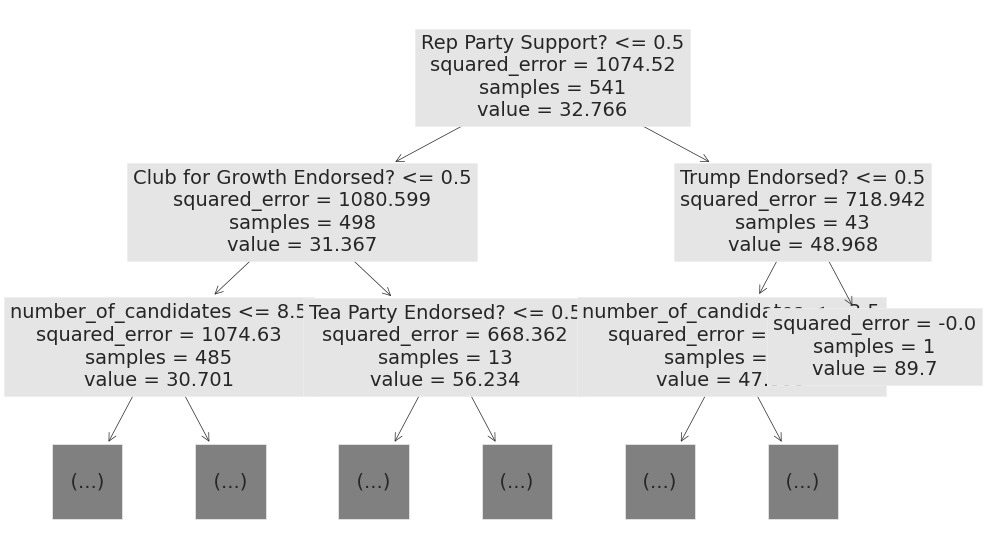

In [171]:
plt.figure(figsize=(12, 7))
plot_tree(rep_tree_model, max_depth=2, fontsize=14, feature_names=rep_X_cols);

In [172]:
dem_forest_model = RandomForestRegressor(max_features=(len(dem_X_cols)//3))

dem_forest_model.fit(dem_train[dem_X_cols], dem_train[dem_y_col])

dem_train["forest_pred"] = dem_forest_model.predict(dem_train[dem_X_cols])
dem_test["forest_pred"] = dem_forest_model.predict(dem_test[dem_X_cols])

rep_forest_model = RandomForestRegressor(max_features=(len(rep_X_cols)//3))

rep_forest_model.fit(rep_train[rep_X_cols], rep_train[rep_y_col])

rep_train["forest_pred"] = rep_forest_model.predict(rep_train[rep_X_cols])
rep_test["forest_pred"] = rep_forest_model.predict(rep_test[rep_X_cols])

In [173]:
dem_train_rmse = np.mean((dem_train["forest_pred"] - dem_train[dem_y_col]) ** 2) ** 0.5
dem_test_rmse = np.mean((dem_test["forest_pred"] - dem_test[dem_y_col]) ** 2) ** 0.5

print("Democratic")
print("Training set error for random forest:", dem_train_rmse)
print("Test set error for random forest:    ", dem_test_rmse)

rep_train_rmse = np.mean((rep_train["forest_pred"] - rep_train[rep_y_col]) ** 2) ** 0.5
rep_test_rmse = np.mean((rep_test["forest_pred"] - rep_test[rep_y_col]) ** 2) ** 0.5

print("Republican")
print("Training set error for random forest:", rep_train_rmse)
print("Test set error for random forest:    ", rep_test_rmse)

Democratic
Training set error for random forest: 11.770242236573342
Test set error for random forest:     14.36528253023979
Republican
Training set error for random forest: 30.223831589402117
Test set error for random forest:     30.382598991756893


In [174]:
print('Democratic:')
print(len(dem_X_cols))
print(dem_X_cols)

print('Republican:')
print(len(rep_X_cols))
print(rep_X_cols)

Democratic:
20
['Veteran?' 'LGBTQ?' 'Elected Official?' 'Self-Funder?' 'STEM?'
 'Obama Alum?' 'Party Support?' 'Emily Endorsed?' 'Guns Sense Candidate?'
 'Biden Endorsed?' 'Warren Endorsed? ' 'Sanders Endorsed?'
 'Our Revolution Endorsed?' 'Justice Dems Endorsed?' 'PCCC Endorsed?'
 'Indivisible Endorsed?' 'WFP Endorsed?' 'VoteVets Endorsed?'
 'No Labels Support?' 'number_of_candidates']
Republican:
14
['Rep Party Support?' 'Trump Endorsed?' 'Bannon Endorsed?'
 'Great America Endorsed?' 'NRA Endorsed?' 'Right to Life Endorsed?'
 'Susan B. Anthony Endorsed?' 'Club for Growth Endorsed?' 'Koch Support?'
 'House Freedom Support?' 'Tea Party Endorsed?' 'Main Street Endorsed?'
 'Chamber Endorsed?' 'number_of_candidates']


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=761f112e-3efb-4066-82d1-326510fb657f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>